# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [14]:
!pip install --upgrade pip
!pip install torch
#!pip install torchvision
#!pip install -U numpy
#!pip show numpy

Traceback (most recent call last):
  File "/anaconda3/bin/pip", line 8, in <module>
    sys.exit(main())
  File "/anaconda3/lib/python3.7/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/anaconda3/lib/python3.7/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1006, in _gcd_import
  File "<frozen importlib._bootstrap>", line 983, in _find_and_load
  File "<frozen importlib._bootstrap>", line 967, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 677, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_f

In [15]:
# can comment out after executing
!unzip processed_celeba_small.zip

unzip:  cannot find or open processed_celeba_small.zip, processed_celeba_small.zip.zip or processed_celeba_small.zip.ZIP.


In [16]:
# necessary imports
import pandas as pd
import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image 
import glob

In [17]:
data_dir = 'processed_celeba_small/'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests


%matplotlib inline

In [18]:
# Parameter settings

train_n = 27
param = 'lr'

# set parameter sets
number_epochs = [1, 10, 50, 100, 500, 1000]
lr_set = [0.001, 0.0005, 0.0002]
batch_size_set = [16, 32, 64, 128, 256, 512]
conv_dim_set = [64, 128, 256]

# default
batch_size = 32
img_size = 32
n_epochs = 100
conv_dim = 64
lr = 0.0002
beta1=0.1
beta2=0.999
z_size = 100

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [19]:
print('Number of images used for the Discriminator Training: ', len(glob.glob("processed_celeba_small/celeba/*.jpg")))

Number of images used for the Discriminator Training:  10674


In [20]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # Tensor transform
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor()
                                    ])
    
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

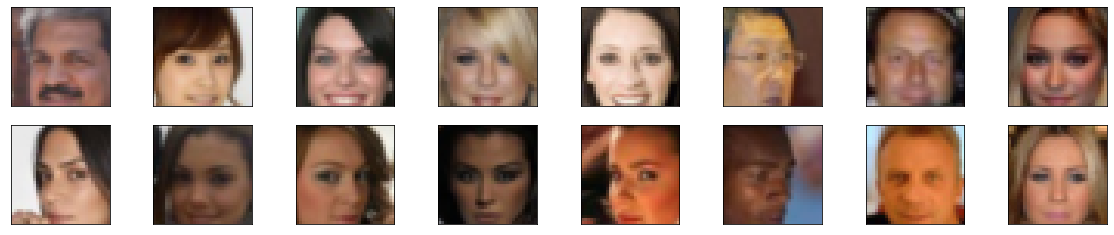

In [22]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=16
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [23]:
fig.savefig('image_sets/orig_examples.png')

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [24]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
     # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x
    

In [25]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.6627)
Max:  tensor(0.5059)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [26]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [27]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = self.dropout(out)
        out = F.leaky_relu(self.conv4(out), 0.2)
        # flatten
        out = out.view(-1, self.conv_dim*8*2*2)
        out = self.dropout(out)
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [28]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [29]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.t_conv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        
        # set dropout layer
        self.dropout = nn.Dropout(p=0.5)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8, 2, 2) # (batch_size, depth, 2, 2)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = self.dropout(out)
        out = F.relu(self.t_conv2(out))
        out = self.dropout(out)
        out = F.relu(self.t_conv3(out))
        out = self.dropout(out)
        # last layer + tanh activation
        out = self.t_conv4(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [30]:
# takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    
    elif hasattr(m, 'weight') and classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


In [32]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [34]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # smooth, real labels = 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models.

In [35]:
# Create optimizers for the discriminator and generator
def optimizer(lr):
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

    return d_optimizer, g_optimizer

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [36]:
# save chosen hyperparameters of the actual training run to an excel file
def save_data(index, losses, batch_size):
    losses = np.array(losses)
    
    # Export Loss as Dataframe
    idx = range(len(losses.T[0]))
    d = {'Discriminator': losses.T[0], 'Generator': losses.T[1]}
    loss_df = pd.DataFrame(data=d, index = idx)
    train_number = train_n + index
    loss_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + ".xlsx")
    
    # Export hyperparameters
    hyper_params = {'batch_size': batch_size,
                'img_size': img_size,
                'deconv-layers': 3,
                'conv-layers': 3,
                'd_conv_dim': d_conv_dim,
                'g_conv_dim': g_conv_dim,
                'z_size': z_size,
                'lr': lr,
                'beta1': beta1,
                'beta2': beta2,
                'dropout': 'no',
                'n_epochs': n_epochs
                }
    hyper_param_df = pd.DataFrame.from_dict(hyper_params, orient='index')
    hyper_param_df.to_excel('training_results/train_' + str(train_number) +'_'+ param + "_hyper_param.xlsx")
    print(hyper_params)

In [37]:
# plot the training losses of Discriminator and Generator for the actual training run
def plot_training_loss(losses):
    print('Plot Loss')
    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
    plt.plot(losses.T[1], label='Generator', alpha=0.5)
    plt.title("Training Losses")
    plt.legend()
    plt.show()

In [38]:
# helper function for viewing a list of passed in sample images
def view_samples(index, epoch=-1):
    print('View Samples')
    train_number = train_n + index
    # Load samples from generator, taken while training
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_samples.pkl', 'rb') as f:
        samples = pkl.load(f)
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [39]:
def train(D, G,  n_epochs, index=0, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    train_number = train_n + index
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ============================================
            #            TRAIN THE DISCRIMINATOR
            # ============================================

            d_optimizer.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()


            # =========================================
            #            TRAIN THE GENERATOR
            # =========================================
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('training_results_pkl/train_' + str(train_number) +'_'+ param + '_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [40]:
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
n_epochs=1
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    1] | d_loss: 1.5877 | g_loss: 0.8818
Epoch [    1/    1] | d_loss: 0.3106 | g_loss: 2.8352
Epoch [    1/    1] | d_loss: 0.1685 | g_loss: 5.0137
Epoch [    1/    1] | d_loss: 0.5284 | g_loss: 3.6153
Epoch [    1/    1] | d_loss: 0.2597 | g_loss: 4.3356
Epoch [    1/    1] | d_loss: 0.0699 | g_loss: 5.3848
Epoch [    1/    1] | d_loss: 0.1750 | g_loss: 4.4209
Epoch [    1/    1] | d_loss: 0.0269 | g_loss: 5.2100
Epoch [    1/    1] | d_loss: 0.0385 | g_loss: 5.2578


Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, ke

Epoch [   14/  100] | d_loss: 0.1587 | g_loss: 2.4232
Epoch [   14/  100] | d_loss: 0.1323 | g_loss: 1.5489
Epoch [   14/  100] | d_loss: 0.0221 | g_loss: 4.5127
Epoch [   14/  100] | d_loss: 0.0337 | g_loss: 3.5322
Epoch [   14/  100] | d_loss: 0.0044 | g_loss: 2.9130
Epoch [   14/  100] | d_loss: 1.5202 | g_loss: 14.1020
Epoch [   15/  100] | d_loss: 2.5562 | g_loss: 10.3915
Epoch [   15/  100] | d_loss: 0.0115 | g_loss: 4.7791
Epoch [   15/  100] | d_loss: 0.1215 | g_loss: 4.6491
Epoch [   15/  100] | d_loss: 0.0433 | g_loss: 5.1827
Epoch [   15/  100] | d_loss: 0.1392 | g_loss: 6.0377
Epoch [   15/  100] | d_loss: 0.1087 | g_loss: 4.3895
Epoch [   15/  100] | d_loss: 0.2008 | g_loss: 2.5710
Epoch [   15/  100] | d_loss: 0.0899 | g_loss: 3.1069
Epoch [   15/  100] | d_loss: 0.2808 | g_loss: 4.3414
Epoch [   16/  100] | d_loss: 0.0643 | g_loss: 3.5249
Epoch [   16/  100] | d_loss: 0.0085 | g_loss: 5.8492
Epoch [   16/  100] | d_loss: 0.1511 | g_loss: 6.7121
Epoch [   16/  100] | d_lo

Epoch [   31/  100] | d_loss: 0.1912 | g_loss: 5.6159
Epoch [   31/  100] | d_loss: 0.0391 | g_loss: 6.7847
Epoch [   31/  100] | d_loss: 0.0560 | g_loss: 5.2938
Epoch [   31/  100] | d_loss: 0.0183 | g_loss: 6.2872
Epoch [   31/  100] | d_loss: 0.0099 | g_loss: 7.0564
Epoch [   31/  100] | d_loss: 0.0489 | g_loss: 8.5605
Epoch [   31/  100] | d_loss: 0.0199 | g_loss: 4.6865
Epoch [   32/  100] | d_loss: 0.0152 | g_loss: 7.8953
Epoch [   32/  100] | d_loss: 0.1784 | g_loss: 8.0311
Epoch [   32/  100] | d_loss: 0.0507 | g_loss: 5.5624
Epoch [   32/  100] | d_loss: 0.0635 | g_loss: 5.3273
Epoch [   32/  100] | d_loss: 0.0174 | g_loss: 6.5579
Epoch [   32/  100] | d_loss: 0.0696 | g_loss: 8.1296
Epoch [   32/  100] | d_loss: 0.0245 | g_loss: 5.9448
Epoch [   32/  100] | d_loss: 0.3152 | g_loss: 5.6584
Epoch [   32/  100] | d_loss: 0.0475 | g_loss: 5.8408
Epoch [   33/  100] | d_loss: 0.0705 | g_loss: 5.0170
Epoch [   33/  100] | d_loss: 0.0414 | g_loss: 7.4697
Epoch [   33/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.0025 | g_loss: 9.4969
Epoch [   48/  100] | d_loss: 3.1671 | g_loss: 19.3566
Epoch [   48/  100] | d_loss: 0.0036 | g_loss: 4.5665
Epoch [   48/  100] | d_loss: 0.0018 | g_loss: 4.7658
Epoch [   48/  100] | d_loss: 0.0054 | g_loss: 10.0264
Epoch [   48/  100] | d_loss: 0.0090 | g_loss: 7.7846
Epoch [   48/  100] | d_loss: 0.0188 | g_loss: 7.0472
Epoch [   48/  100] | d_loss: 0.0979 | g_loss: 5.5763
Epoch [   49/  100] | d_loss: 0.0102 | g_loss: 6.6352
Epoch [   49/  100] | d_loss: 0.3159 | g_loss: 11.7929
Epoch [   49/  100] | d_loss: 0.0411 | g_loss: 12.4995
Epoch [   49/  100] | d_loss: 0.3441 | g_loss: 10.0180
Epoch [   49/  100] | d_loss: 0.0019 | g_loss: 7.8423
Epoch [   49/  100] | d_loss: 0.1617 | g_loss: 7.3585
Epoch [   49/  100] | d_loss: 0.0561 | g_loss: 7.3437
Epoch [   49/  100] | d_loss: 0.0145 | g_loss: 9.2291
Epoch [   49/  100] | d_loss: 0.0381 | g_loss: 6.9404
Epoch [   50/  100] | d_loss: 0.0342 | g_loss: 9.1497
Epoch [   50/  100] | d

Epoch [   65/  100] | d_loss: 0.0180 | g_loss: 7.2263
Epoch [   65/  100] | d_loss: 0.0007 | g_loss: 11.7490
Epoch [   65/  100] | d_loss: 0.0002 | g_loss: 8.5431
Epoch [   65/  100] | d_loss: 0.0002 | g_loss: 9.6926
Epoch [   65/  100] | d_loss: 0.0051 | g_loss: 7.3946
Epoch [   65/  100] | d_loss: 0.0071 | g_loss: 7.2054
Epoch [   65/  100] | d_loss: 0.0138 | g_loss: 6.8881
Epoch [   65/  100] | d_loss: 0.0020 | g_loss: 7.0157
Epoch [   65/  100] | d_loss: 0.0154 | g_loss: 7.2582
Epoch [   66/  100] | d_loss: 0.0044 | g_loss: 8.1293
Epoch [   66/  100] | d_loss: 0.0196 | g_loss: 9.4481
Epoch [   66/  100] | d_loss: 0.0032 | g_loss: 9.5697
Epoch [   66/  100] | d_loss: 0.0011 | g_loss: 8.2758
Epoch [   66/  100] | d_loss: 0.0004 | g_loss: 8.5318
Epoch [   66/  100] | d_loss: 0.0140 | g_loss: 8.2354
Epoch [   66/  100] | d_loss: 0.0008 | g_loss: 13.1153
Epoch [   66/  100] | d_loss: 0.0005 | g_loss: 9.3409
Epoch [   66/  100] | d_loss: 0.0004 | g_loss: 6.6297
Epoch [   67/  100] | d_lo

Epoch [   81/  100] | d_loss: 0.0052 | g_loss: 7.2415
Epoch [   82/  100] | d_loss: 0.0010 | g_loss: 7.6197
Epoch [   82/  100] | d_loss: 0.0025 | g_loss: 10.0892
Epoch [   82/  100] | d_loss: 0.0002 | g_loss: 5.9656
Epoch [   82/  100] | d_loss: 0.0264 | g_loss: 6.7597
Epoch [   82/  100] | d_loss: 0.0025 | g_loss: 4.5753
Epoch [   82/  100] | d_loss: 1.7544 | g_loss: 8.7511
Epoch [   82/  100] | d_loss: 0.0055 | g_loss: 5.4537
Epoch [   82/  100] | d_loss: 0.1317 | g_loss: 11.5455
Epoch [   82/  100] | d_loss: 0.0001 | g_loss: 5.7494
Epoch [   83/  100] | d_loss: 0.0128 | g_loss: 8.7395
Epoch [   83/  100] | d_loss: 0.0069 | g_loss: 8.3134
Epoch [   83/  100] | d_loss: 0.0077 | g_loss: 6.8341
Epoch [   83/  100] | d_loss: 0.0086 | g_loss: 9.3355
Epoch [   83/  100] | d_loss: 0.0011 | g_loss: 12.6847
Epoch [   83/  100] | d_loss: 0.0000 | g_loss: 10.7322
Epoch [   83/  100] | d_loss: 0.1254 | g_loss: 6.6467
Epoch [   83/  100] | d_loss: 0.0014 | g_loss: 9.8149
Epoch [   83/  100] | d_

Epoch [   98/  100] | d_loss: 0.0553 | g_loss: 7.6735
Epoch [   98/  100] | d_loss: 0.0051 | g_loss: 9.0960
Epoch [   99/  100] | d_loss: 0.0024 | g_loss: 4.4412
Epoch [   99/  100] | d_loss: 0.0090 | g_loss: 5.1374
Epoch [   99/  100] | d_loss: 0.0106 | g_loss: 6.3200
Epoch [   99/  100] | d_loss: 0.0151 | g_loss: 8.3557
Epoch [   99/  100] | d_loss: 0.2150 | g_loss: 2.1073
Epoch [   99/  100] | d_loss: 0.0424 | g_loss: 4.8605
Epoch [   99/  100] | d_loss: 0.0850 | g_loss: 10.1085
Epoch [   99/  100] | d_loss: 2.8419 | g_loss: 25.4125
Epoch [   99/  100] | d_loss: 0.2195 | g_loss: 10.4658
Epoch [  100/  100] | d_loss: 0.0034 | g_loss: 12.1630
Epoch [  100/  100] | d_loss: 0.0022 | g_loss: 13.3950
Epoch [  100/  100] | d_loss: 0.0150 | g_loss: 6.8859
Epoch [  100/  100] | d_loss: 0.0011 | g_loss: 9.2845
Epoch [  100/  100] | d_loss: 0.0015 | g_loss: 7.8925
Epoch [  100/  100] | d_loss: 0.0007 | g_loss: 10.6673
Epoch [  100/  100] | d_loss: 0.0030 | g_loss: 5.1080
Epoch [  100/  100] | 

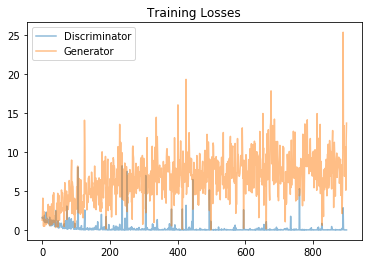

View Samples


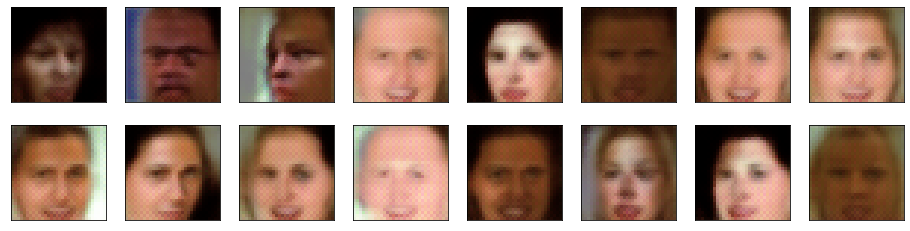

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, ke

Epoch [   14/  100] | d_loss: 0.1076 | g_loss: 4.5653
Epoch [   14/  100] | d_loss: 0.1377 | g_loss: 2.7785
Epoch [   14/  100] | d_loss: 1.9997 | g_loss: 8.1933
Epoch [   14/  100] | d_loss: 0.0475 | g_loss: 1.2129
Epoch [   14/  100] | d_loss: 0.0856 | g_loss: 3.6294
Epoch [   14/  100] | d_loss: 0.2803 | g_loss: 4.8687
Epoch [   15/  100] | d_loss: 0.6945 | g_loss: 7.2612
Epoch [   15/  100] | d_loss: 0.1062 | g_loss: 3.4312
Epoch [   15/  100] | d_loss: 0.0720 | g_loss: 3.7947
Epoch [   15/  100] | d_loss: 0.2083 | g_loss: 4.5570
Epoch [   15/  100] | d_loss: 0.1240 | g_loss: 1.7018
Epoch [   15/  100] | d_loss: 0.2046 | g_loss: 3.5844
Epoch [   15/  100] | d_loss: 0.0266 | g_loss: 2.2097
Epoch [   15/  100] | d_loss: 0.3408 | g_loss: 1.7089
Epoch [   15/  100] | d_loss: 0.0370 | g_loss: 4.9199
Epoch [   16/  100] | d_loss: 0.0350 | g_loss: 5.8243
Epoch [   16/  100] | d_loss: 0.4919 | g_loss: 3.4556
Epoch [   16/  100] | d_loss: 0.0277 | g_loss: 4.0974
Epoch [   16/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.0035 | g_loss: 7.0234
Epoch [   31/  100] | d_loss: 0.0195 | g_loss: 6.6482
Epoch [   31/  100] | d_loss: 1.1672 | g_loss: 2.5687
Epoch [   31/  100] | d_loss: 0.4414 | g_loss: 12.6994
Epoch [   31/  100] | d_loss: 0.0334 | g_loss: 6.3058
Epoch [   31/  100] | d_loss: 0.0660 | g_loss: 5.6439
Epoch [   31/  100] | d_loss: 0.0841 | g_loss: 7.9656
Epoch [   32/  100] | d_loss: 0.0816 | g_loss: 4.4920
Epoch [   32/  100] | d_loss: 0.0662 | g_loss: 6.6098
Epoch [   32/  100] | d_loss: 0.0700 | g_loss: 3.7849
Epoch [   32/  100] | d_loss: 0.0288 | g_loss: 4.6227
Epoch [   32/  100] | d_loss: 0.0100 | g_loss: 8.7322
Epoch [   32/  100] | d_loss: 0.0533 | g_loss: 3.7567
Epoch [   32/  100] | d_loss: 0.0428 | g_loss: 2.0031
Epoch [   32/  100] | d_loss: 0.0182 | g_loss: 9.1219
Epoch [   32/  100] | d_loss: 0.0026 | g_loss: 6.6399
Epoch [   33/  100] | d_loss: 0.0089 | g_loss: 8.1223
Epoch [   33/  100] | d_loss: 0.1978 | g_loss: 5.2099
Epoch [   33/  100] | d_los

Epoch [   48/  100] | d_loss: 0.0229 | g_loss: 8.1091
Epoch [   48/  100] | d_loss: 0.0456 | g_loss: 7.6059
Epoch [   48/  100] | d_loss: 0.0083 | g_loss: 8.6121
Epoch [   48/  100] | d_loss: 0.0124 | g_loss: 5.7805
Epoch [   48/  100] | d_loss: 0.0103 | g_loss: 7.7686
Epoch [   48/  100] | d_loss: 0.0461 | g_loss: 2.7666
Epoch [   48/  100] | d_loss: 0.0196 | g_loss: 6.0328
Epoch [   48/  100] | d_loss: 0.0112 | g_loss: 6.0729
Epoch [   49/  100] | d_loss: 0.1139 | g_loss: 6.4435
Epoch [   49/  100] | d_loss: 0.0450 | g_loss: 5.6638
Epoch [   49/  100] | d_loss: 0.0079 | g_loss: 6.4771
Epoch [   49/  100] | d_loss: 0.0035 | g_loss: 7.1195
Epoch [   49/  100] | d_loss: 0.0205 | g_loss: 7.6670
Epoch [   49/  100] | d_loss: 0.0769 | g_loss: 3.2396
Epoch [   49/  100] | d_loss: 0.0961 | g_loss: 6.2383
Epoch [   49/  100] | d_loss: 0.0378 | g_loss: 4.5010
Epoch [   49/  100] | d_loss: 0.0602 | g_loss: 2.0587
Epoch [   50/  100] | d_loss: 0.0372 | g_loss: 5.5576
Epoch [   50/  100] | d_loss

Epoch [   65/  100] | d_loss: 0.0090 | g_loss: 7.3424
Epoch [   65/  100] | d_loss: 0.0440 | g_loss: 7.7925
Epoch [   65/  100] | d_loss: 0.0207 | g_loss: 8.3962
Epoch [   65/  100] | d_loss: 0.0325 | g_loss: 8.2553
Epoch [   65/  100] | d_loss: 0.0045 | g_loss: 9.1492
Epoch [   65/  100] | d_loss: 0.0048 | g_loss: 7.2252
Epoch [   65/  100] | d_loss: 0.0015 | g_loss: 8.1304
Epoch [   65/  100] | d_loss: 0.0009 | g_loss: 9.0407
Epoch [   65/  100] | d_loss: 0.0264 | g_loss: 5.1958
Epoch [   66/  100] | d_loss: 0.0452 | g_loss: 7.8834
Epoch [   66/  100] | d_loss: 0.2653 | g_loss: 9.8697
Epoch [   66/  100] | d_loss: 0.1288 | g_loss: 6.5805
Epoch [   66/  100] | d_loss: 0.2239 | g_loss: 4.1318
Epoch [   66/  100] | d_loss: 0.0110 | g_loss: 3.3177
Epoch [   66/  100] | d_loss: 0.0067 | g_loss: 7.7768
Epoch [   66/  100] | d_loss: 0.0111 | g_loss: 5.8099
Epoch [   66/  100] | d_loss: 0.0005 | g_loss: 7.0971
Epoch [   66/  100] | d_loss: 0.0772 | g_loss: 2.5815
Epoch [   67/  100] | d_loss

Epoch [   81/  100] | d_loss: 0.0024 | g_loss: 5.8462
Epoch [   82/  100] | d_loss: 0.0353 | g_loss: 4.9061
Epoch [   82/  100] | d_loss: 0.0099 | g_loss: 7.6579
Epoch [   82/  100] | d_loss: 0.0011 | g_loss: 7.6230
Epoch [   82/  100] | d_loss: 0.0093 | g_loss: 7.6520
Epoch [   82/  100] | d_loss: 0.0261 | g_loss: 10.3961
Epoch [   82/  100] | d_loss: 0.0070 | g_loss: 7.7663
Epoch [   82/  100] | d_loss: 0.0007 | g_loss: 7.3065
Epoch [   82/  100] | d_loss: 0.0028 | g_loss: 6.2581
Epoch [   82/  100] | d_loss: 0.0044 | g_loss: 11.0997
Epoch [   83/  100] | d_loss: 0.0005 | g_loss: 5.5031
Epoch [   83/  100] | d_loss: 0.0034 | g_loss: 11.1350
Epoch [   83/  100] | d_loss: 0.0009 | g_loss: 8.5526
Epoch [   83/  100] | d_loss: 0.0041 | g_loss: 4.2110
Epoch [   83/  100] | d_loss: 0.0002 | g_loss: 10.9135
Epoch [   83/  100] | d_loss: 0.0042 | g_loss: 8.9600
Epoch [   83/  100] | d_loss: 0.0129 | g_loss: 4.8951
Epoch [   83/  100] | d_loss: 13.2782 | g_loss: 7.0168
Epoch [   83/  100] | d

Epoch [   98/  100] | d_loss: 0.0373 | g_loss: 8.2839
Epoch [   98/  100] | d_loss: 0.0017 | g_loss: 5.5340
Epoch [   98/  100] | d_loss: 0.0012 | g_loss: 8.6968
Epoch [   99/  100] | d_loss: 0.0153 | g_loss: 6.4746
Epoch [   99/  100] | d_loss: 0.0166 | g_loss: 9.1089
Epoch [   99/  100] | d_loss: 0.0004 | g_loss: 10.9127
Epoch [   99/  100] | d_loss: 0.0027 | g_loss: 8.1988
Epoch [   99/  100] | d_loss: 0.0082 | g_loss: 7.6949
Epoch [   99/  100] | d_loss: 0.0483 | g_loss: 6.5444
Epoch [   99/  100] | d_loss: 0.0023 | g_loss: 7.0573
Epoch [   99/  100] | d_loss: 0.0146 | g_loss: 10.2387
Epoch [   99/  100] | d_loss: 0.0003 | g_loss: 8.1753
Epoch [  100/  100] | d_loss: 0.0123 | g_loss: 7.3520
Epoch [  100/  100] | d_loss: 0.0048 | g_loss: 6.1446
Epoch [  100/  100] | d_loss: 0.0004 | g_loss: 9.7211
Epoch [  100/  100] | d_loss: 0.0085 | g_loss: 6.9413
Epoch [  100/  100] | d_loss: 0.0069 | g_loss: 8.4648
Epoch [  100/  100] | d_loss: 0.0106 | g_loss: 7.6203
Epoch [  100/  100] | d_lo

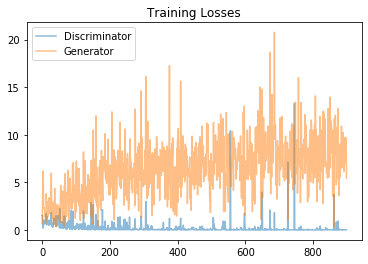

View Samples


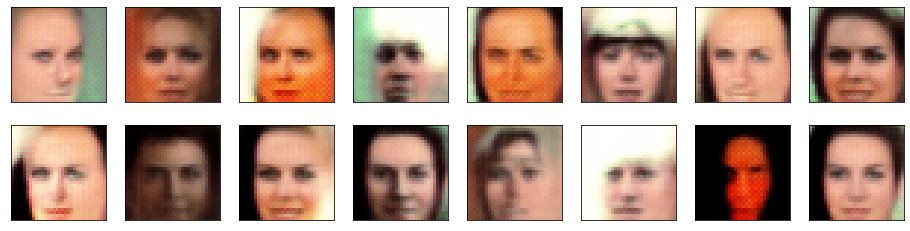

Build Network
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(512, 256, ke

Epoch [   14/  100] | d_loss: 0.3417 | g_loss: 4.3311
Epoch [   14/  100] | d_loss: 0.0915 | g_loss: 3.9472
Epoch [   14/  100] | d_loss: 0.1746 | g_loss: 4.0870
Epoch [   14/  100] | d_loss: 0.2467 | g_loss: 4.8024
Epoch [   14/  100] | d_loss: 0.0286 | g_loss: 4.8052
Epoch [   14/  100] | d_loss: 0.6617 | g_loss: 5.5893
Epoch [   15/  100] | d_loss: 0.0540 | g_loss: 5.0325
Epoch [   15/  100] | d_loss: 1.6763 | g_loss: 8.2445
Epoch [   15/  100] | d_loss: 0.0505 | g_loss: 5.3749
Epoch [   15/  100] | d_loss: 2.0182 | g_loss: 2.8801
Epoch [   15/  100] | d_loss: 0.0098 | g_loss: 5.9939
Epoch [   15/  100] | d_loss: 0.2221 | g_loss: 5.8185
Epoch [   15/  100] | d_loss: 0.0506 | g_loss: 5.5529
Epoch [   15/  100] | d_loss: 0.0547 | g_loss: 3.2925
Epoch [   15/  100] | d_loss: 0.0933 | g_loss: 1.9034
Epoch [   16/  100] | d_loss: 0.0423 | g_loss: 3.5792
Epoch [   16/  100] | d_loss: 0.0489 | g_loss: 5.1787
Epoch [   16/  100] | d_loss: 0.0239 | g_loss: 6.4530
Epoch [   16/  100] | d_loss

Epoch [   31/  100] | d_loss: 0.0860 | g_loss: 5.0684
Epoch [   31/  100] | d_loss: 0.0631 | g_loss: 6.2340
Epoch [   31/  100] | d_loss: 0.0694 | g_loss: 6.0517
Epoch [   31/  100] | d_loss: 0.0190 | g_loss: 7.2218
Epoch [   31/  100] | d_loss: 0.1904 | g_loss: 5.6200
Epoch [   31/  100] | d_loss: 0.0379 | g_loss: 9.2316
Epoch [   31/  100] | d_loss: 0.1575 | g_loss: 7.1769
Epoch [   32/  100] | d_loss: 0.0599 | g_loss: 6.9790
Epoch [   32/  100] | d_loss: 0.0179 | g_loss: 6.1376
Epoch [   32/  100] | d_loss: 2.3243 | g_loss: 3.8241
Epoch [   32/  100] | d_loss: 0.0099 | g_loss: 7.0772
Epoch [   32/  100] | d_loss: 0.5741 | g_loss: 4.9613
Epoch [   32/  100] | d_loss: 0.0571 | g_loss: 3.8856
Epoch [   32/  100] | d_loss: 0.2319 | g_loss: 4.1454
Epoch [   32/  100] | d_loss: 0.0737 | g_loss: 5.2185
Epoch [   32/  100] | d_loss: 0.0217 | g_loss: 4.1720
Epoch [   33/  100] | d_loss: 0.1264 | g_loss: 5.0644
Epoch [   33/  100] | d_loss: 0.0376 | g_loss: 5.3368
Epoch [   33/  100] | d_loss

Epoch [   48/  100] | d_loss: 0.0105 | g_loss: 7.0996
Epoch [   48/  100] | d_loss: 0.0017 | g_loss: 7.1451
Epoch [   48/  100] | d_loss: 0.0182 | g_loss: 5.5816
Epoch [   48/  100] | d_loss: 0.0273 | g_loss: 4.0039
Epoch [   48/  100] | d_loss: 0.2995 | g_loss: 3.5053
Epoch [   48/  100] | d_loss: 0.0175 | g_loss: 7.2744
Epoch [   48/  100] | d_loss: 0.0087 | g_loss: 10.2623
Epoch [   48/  100] | d_loss: 0.0654 | g_loss: 8.9655
Epoch [   49/  100] | d_loss: 0.2027 | g_loss: 2.3619
Epoch [   49/  100] | d_loss: 0.0126 | g_loss: 6.7373
Epoch [   49/  100] | d_loss: 0.0748 | g_loss: 9.3475
Epoch [   49/  100] | d_loss: 0.0083 | g_loss: 5.9301
Epoch [   49/  100] | d_loss: 0.1552 | g_loss: 6.6899
Epoch [   49/  100] | d_loss: 0.0281 | g_loss: 6.4005
Epoch [   49/  100] | d_loss: 0.2831 | g_loss: 10.0382
Epoch [   49/  100] | d_loss: 0.0296 | g_loss: 6.7540
Epoch [   49/  100] | d_loss: 0.0262 | g_loss: 5.6541
Epoch [   50/  100] | d_loss: 0.0138 | g_loss: 9.4824
Epoch [   50/  100] | d_lo

Epoch [   65/  100] | d_loss: 0.0181 | g_loss: 5.7344
Epoch [   65/  100] | d_loss: 0.0015 | g_loss: 10.0524
Epoch [   65/  100] | d_loss: 0.0591 | g_loss: 7.7088
Epoch [   65/  100] | d_loss: 0.0862 | g_loss: 7.0507
Epoch [   65/  100] | d_loss: 0.0051 | g_loss: 9.8391
Epoch [   65/  100] | d_loss: 0.0031 | g_loss: 3.9592
Epoch [   65/  100] | d_loss: 0.0301 | g_loss: 7.2689
Epoch [   65/  100] | d_loss: 0.0016 | g_loss: 7.1257
Epoch [   65/  100] | d_loss: 0.0195 | g_loss: 7.9570
Epoch [   66/  100] | d_loss: 0.0010 | g_loss: 8.1249
Epoch [   66/  100] | d_loss: 0.0004 | g_loss: 9.6924
Epoch [   66/  100] | d_loss: 0.0069 | g_loss: 7.6357
Epoch [   66/  100] | d_loss: 0.0032 | g_loss: 5.5493
Epoch [   66/  100] | d_loss: 0.2526 | g_loss: 2.0299
Epoch [   66/  100] | d_loss: 0.0036 | g_loss: 5.0539
Epoch [   66/  100] | d_loss: 0.0887 | g_loss: 3.7737
Epoch [   66/  100] | d_loss: 0.0108 | g_loss: 4.9205
Epoch [   66/  100] | d_loss: 0.0051 | g_loss: 3.4136
Epoch [   67/  100] | d_los

Epoch [   81/  100] | d_loss: 0.0014 | g_loss: 8.1876
Epoch [   82/  100] | d_loss: 0.0906 | g_loss: 7.2843
Epoch [   82/  100] | d_loss: 0.4060 | g_loss: 7.8836
Epoch [   82/  100] | d_loss: 0.0111 | g_loss: 7.2226
Epoch [   82/  100] | d_loss: 0.0158 | g_loss: 6.9665
Epoch [   82/  100] | d_loss: 0.0055 | g_loss: 6.9704
Epoch [   82/  100] | d_loss: 0.0999 | g_loss: 7.7780
Epoch [   82/  100] | d_loss: 0.0369 | g_loss: 6.6992
Epoch [   82/  100] | d_loss: 0.0403 | g_loss: 5.0637
Epoch [   82/  100] | d_loss: 0.0222 | g_loss: 5.9638
Epoch [   83/  100] | d_loss: 0.0576 | g_loss: 4.5388
Epoch [   83/  100] | d_loss: 0.2606 | g_loss: 10.8564
Epoch [   83/  100] | d_loss: 0.0032 | g_loss: 8.8308
Epoch [   83/  100] | d_loss: 0.0129 | g_loss: 8.1202
Epoch [   83/  100] | d_loss: 0.3007 | g_loss: 6.7310
Epoch [   83/  100] | d_loss: 0.0150 | g_loss: 8.2626
Epoch [   83/  100] | d_loss: 0.0001 | g_loss: 6.7526
Epoch [   83/  100] | d_loss: 0.0002 | g_loss: 7.0889
Epoch [   83/  100] | d_los

Epoch [   98/  100] | d_loss: 0.0002 | g_loss: 6.1907
Epoch [   98/  100] | d_loss: 0.0182 | g_loss: 5.8859
Epoch [   99/  100] | d_loss: 0.0023 | g_loss: 8.0770
Epoch [   99/  100] | d_loss: 0.0002 | g_loss: 8.8255
Epoch [   99/  100] | d_loss: 0.0007 | g_loss: 6.3055
Epoch [   99/  100] | d_loss: 0.0051 | g_loss: 7.7945
Epoch [   99/  100] | d_loss: 0.0032 | g_loss: 8.2454
Epoch [   99/  100] | d_loss: 0.0028 | g_loss: 9.5496
Epoch [   99/  100] | d_loss: 0.0182 | g_loss: 10.0429
Epoch [   99/  100] | d_loss: 0.0596 | g_loss: 11.7087
Epoch [   99/  100] | d_loss: 0.0047 | g_loss: 11.3965
Epoch [  100/  100] | d_loss: 0.0004 | g_loss: 6.6593
Epoch [  100/  100] | d_loss: 0.0117 | g_loss: 3.2770
Epoch [  100/  100] | d_loss: 0.0123 | g_loss: 8.0571
Epoch [  100/  100] | d_loss: 0.0028 | g_loss: 4.9036
Epoch [  100/  100] | d_loss: 0.0261 | g_loss: 5.3446
Epoch [  100/  100] | d_loss: 0.0040 | g_loss: 8.4305
Epoch [  100/  100] | d_loss: 0.0746 | g_loss: 5.0934
Epoch [  100/  100] | d_l

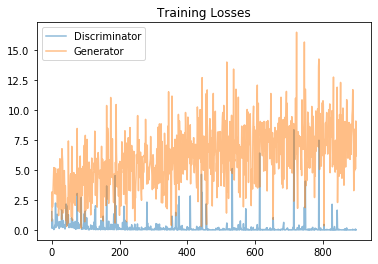

View Samples


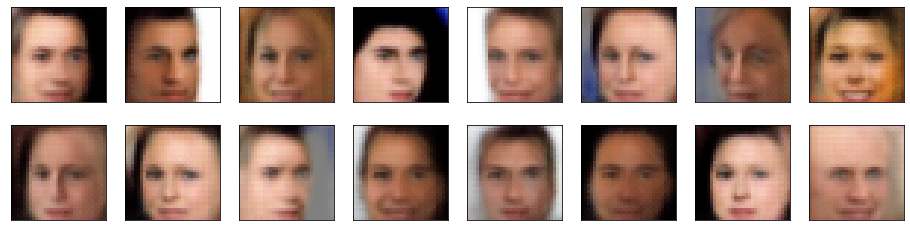

In [41]:
# tune hyperparameters by calling the training function in a loop
n_epochs=100
#for index, n_epochs in enumerate(number_epochs):
#for index, conv_dim in enumerate(conv_dim_set):
#for index, batch_size in enumerate(batch_size_set):
for index, lr in enumerate(lr_set):
    # Set Parameter
    n_epochs = n_epochs
    lr = lr
    batch_size = batch_size
    d_conv_dim = conv_dim
    g_conv_dim = conv_dim
    
    # Get dataloader
    celeba_train_loader = get_dataloader(batch_size, img_size)
    
    # Build network
    print('Build Network')
    D, G = build_network(d_conv_dim, g_conv_dim, z_size)
    
    # Reset optimizer
    d_optimizer, g_optimizer = optimizer(lr)
    
    # Calculate losses
    losses = train(D, G, n_epochs=n_epochs, index=index)
    
    # Save and Plot Data
    save_data(index, losses, batch_size)
    plot_training_loss(losses)
    _ = view_samples(index, epoch=-1)
    

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

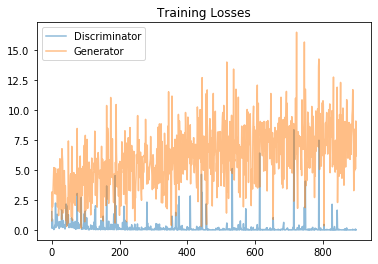

In [42]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [43]:
# helper function for viewing and a list of passed in sample images
def view_samples_2(epoch, samples, train_num):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))
    fig.savefig('image_sets/train_' + str(train_num) + '.png')

In [44]:
# helper function for viewing saving a list of stored training losses of the Discriminator and Generator
def view_plots(train_runs, title, param):
    number_of_pots = len(train_runs)
    train_run_list = [m[0] for m in train_runs]
    param_list = [m[1] for m in train_runs]
    epochs_calc = [m[2] for m in train_runs]
    
    ax_set = ('a' + str(m) for m in range(number_of_pots))
    
    fig, ax_set = plt.subplots(figsize=(16,4), nrows=1, ncols=number_of_pots)
    fig.suptitle(title)
    for ii,train_num in enumerate(train_run_list):
        df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param_list[ii]) + '.xlsx')  # doctest: +SKIP
        loss_d = df['Discriminator'].values
        loss_g = df['Generator'].values
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_d, label='Discriminator')
        ax_set[ii].plot(df.index/epochs_calc[ii], loss_g, label='Generator')
        ax_set[ii].set_title('Train_' + str(train_num))
        #ax_set[ii].xlabel('n_epochs', fontsize=14)
        #ax_set[iniidex].ylabel('loss', fontsize=14)
        ax_set[ii].legend()
        
    fig.savefig('plots/train_' + str(param) + '.png')

In the following section the parameter tuning which was investigated in separated training runs is appended. 

## Parameter: n_epochs

Parameters          | 1st Train-Run | 2nd Train-Run | 3rd Train-Run | 4th Train-Run | 5th Train-Run | 6th Train-Run |
----------          | ------------- | ------------- | ------------- | ------------- | ------------- | ------------- |
batch_size          |   128         |   128         |   128         |   128         |   128         |   128         |
img_size            |   32          |   32          |   32          |   32          |   32          |   32          |
deconv-layers       |   3           |   3           |   3           |   3           |   3           |   3           |
conv-layers         |   3           |   3           |   3           |   3           |   3           |   3           |
d_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
g_conv_dim          |   32          |   32          |   32          |   32          |   32          |   32          |
z_size              |   100         |   100         |   100         |   100         |   100         |   100         |
lr                  |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |   0.5         |
beta2               |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |   0.999       |
dropout             |   no          |   no          |   no          |   no          |   no          |   no          |
**n_epochs**        |   `1`         |   `10`        |   `50`        |   `100`       |   `500`       |   `1000`      |

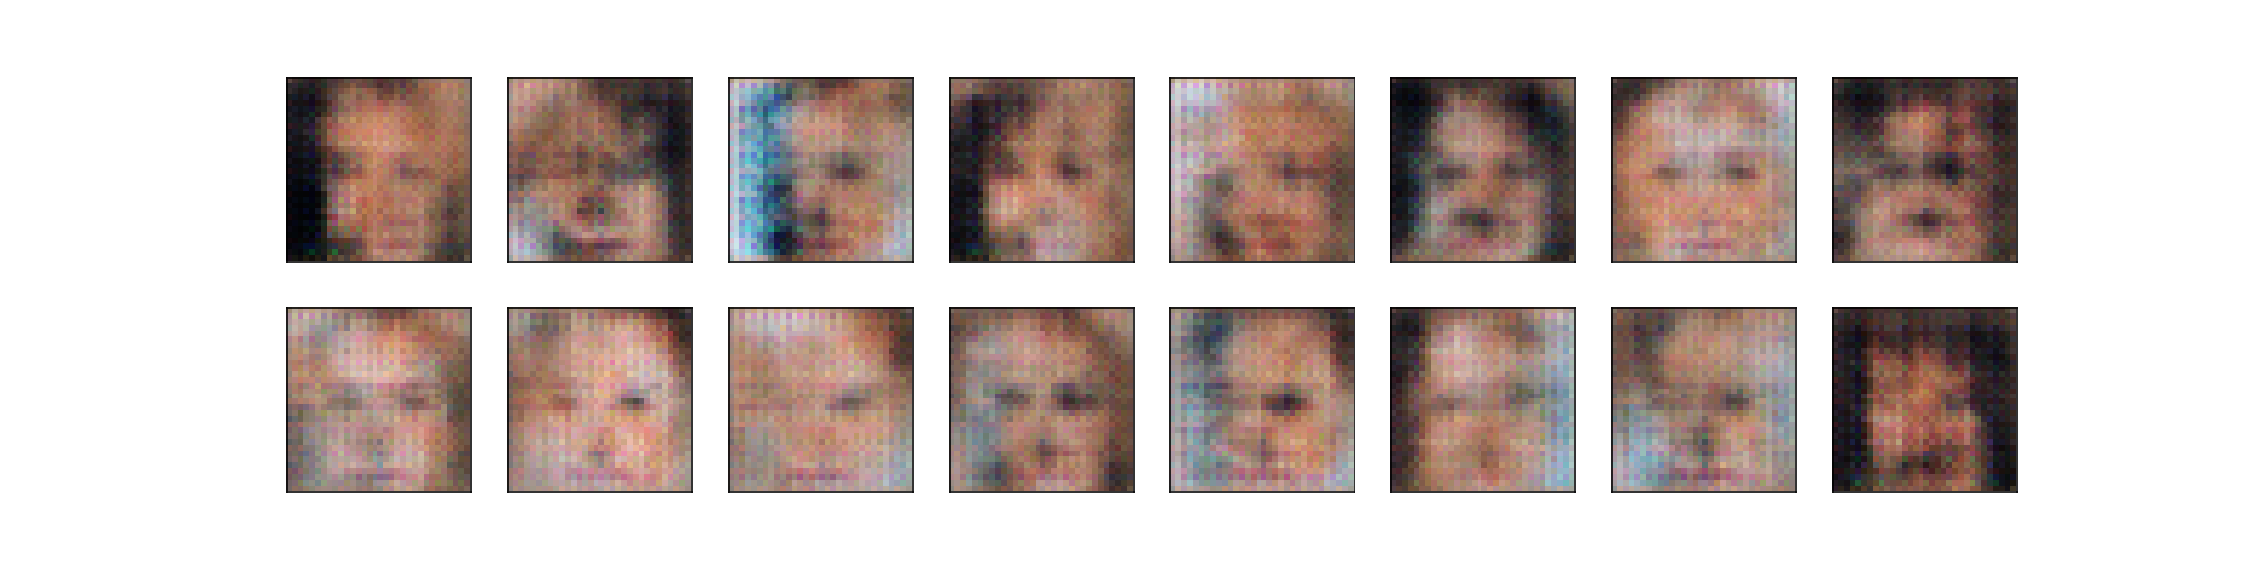

In [45]:
# n_epochs = 1
train_num = 1
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

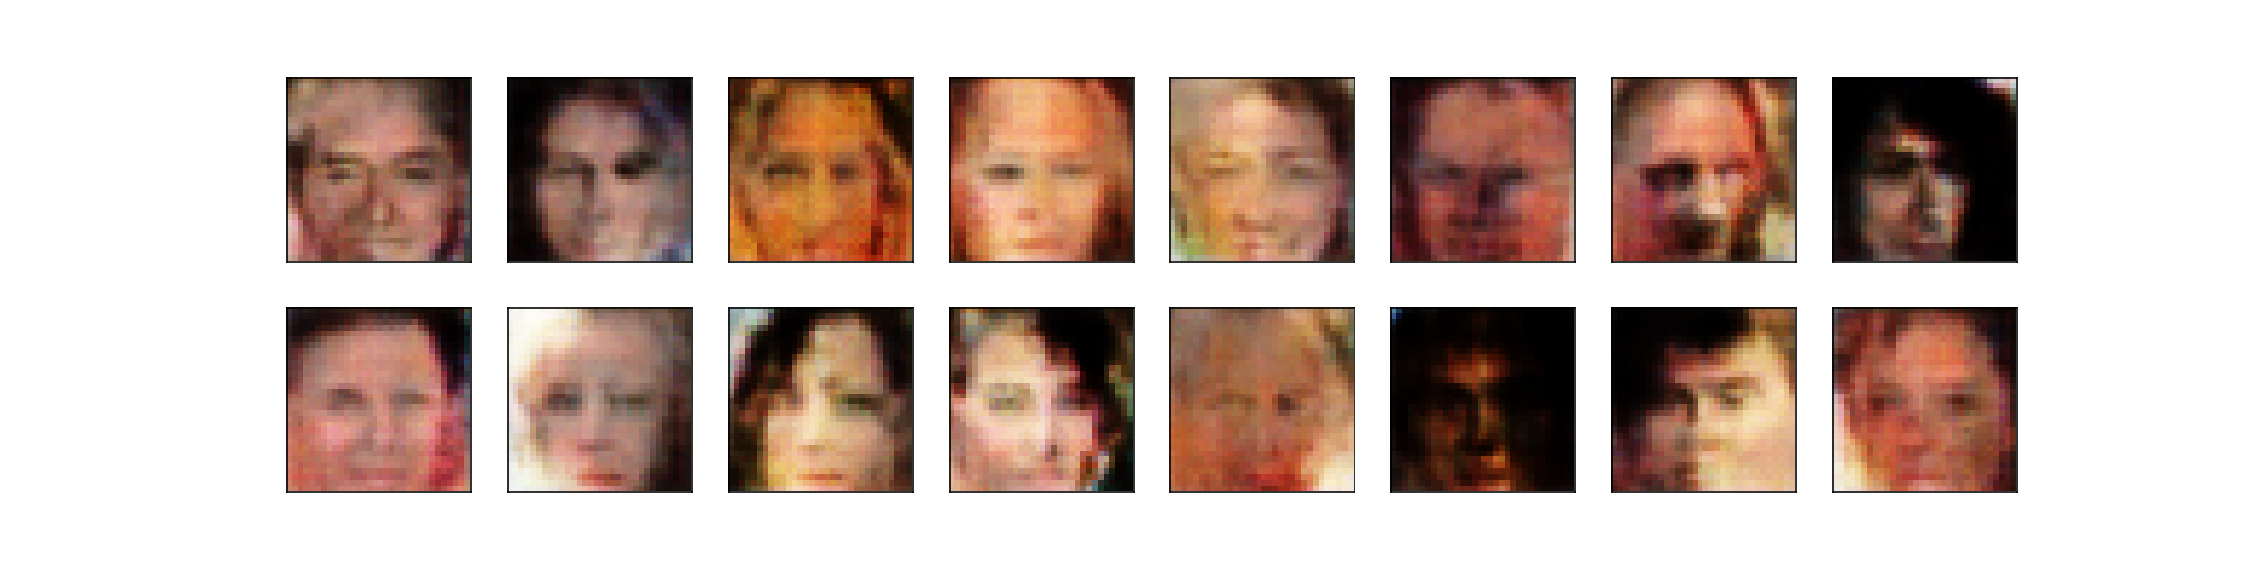

In [46]:
# n_epochs = 10
train_num = 2
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

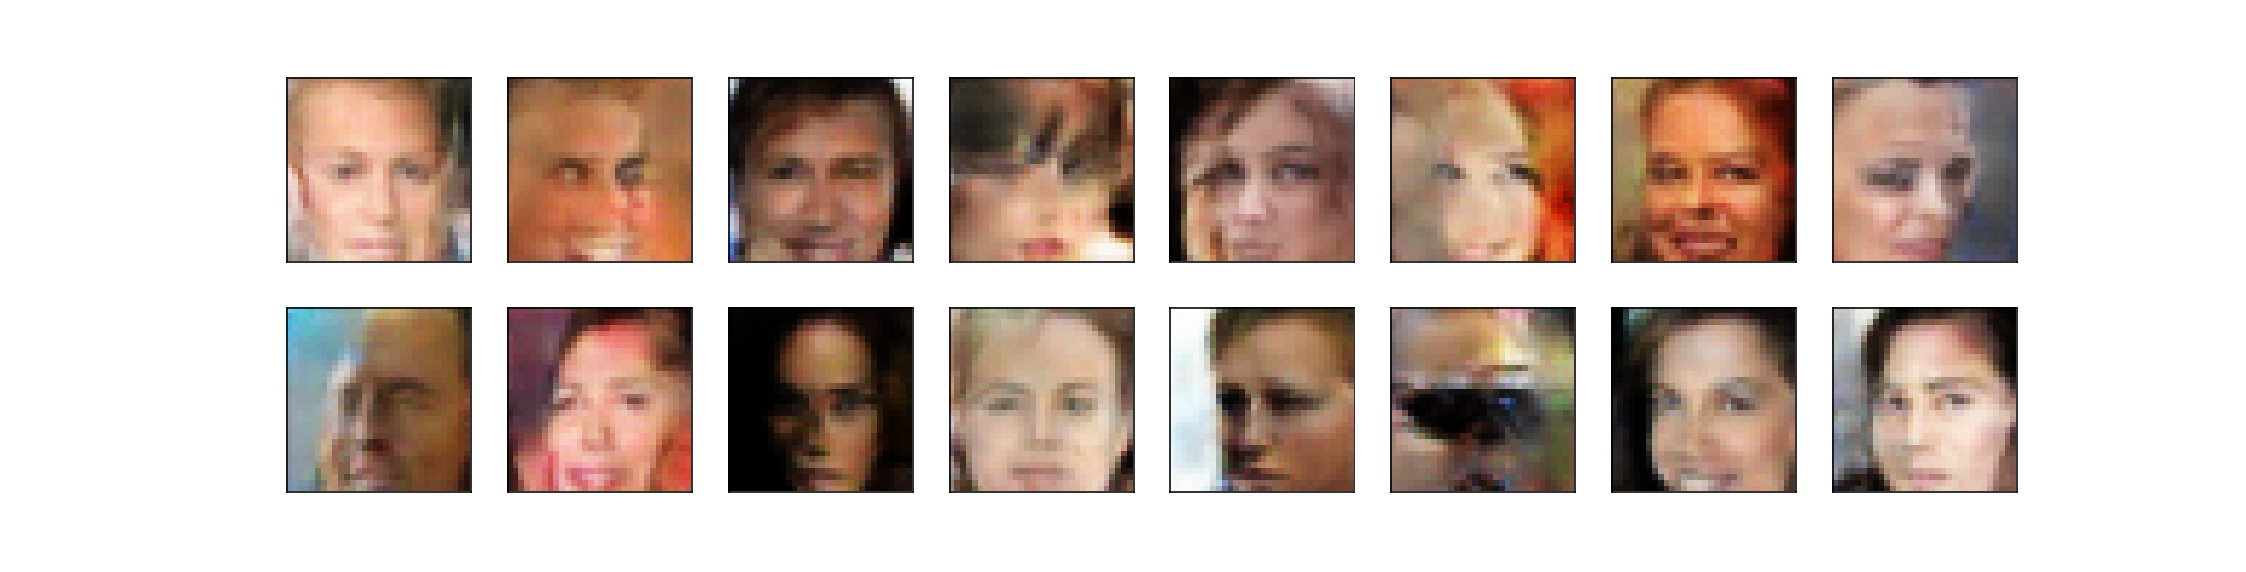

In [47]:
# n_epochs = 50
train_num = 3
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

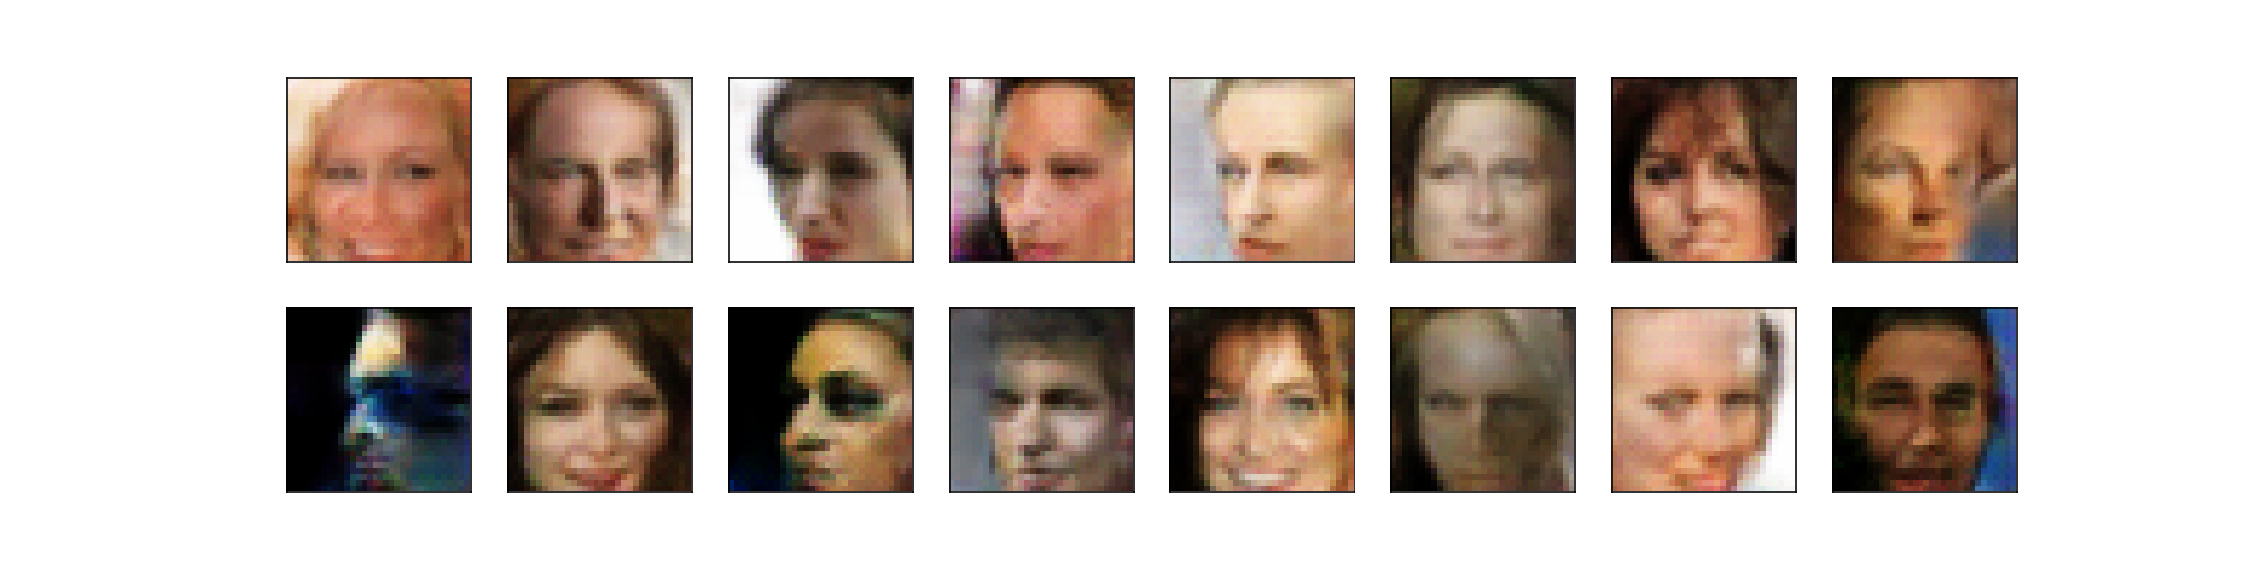

In [48]:
# n_epochs = 100
train_num = 4
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

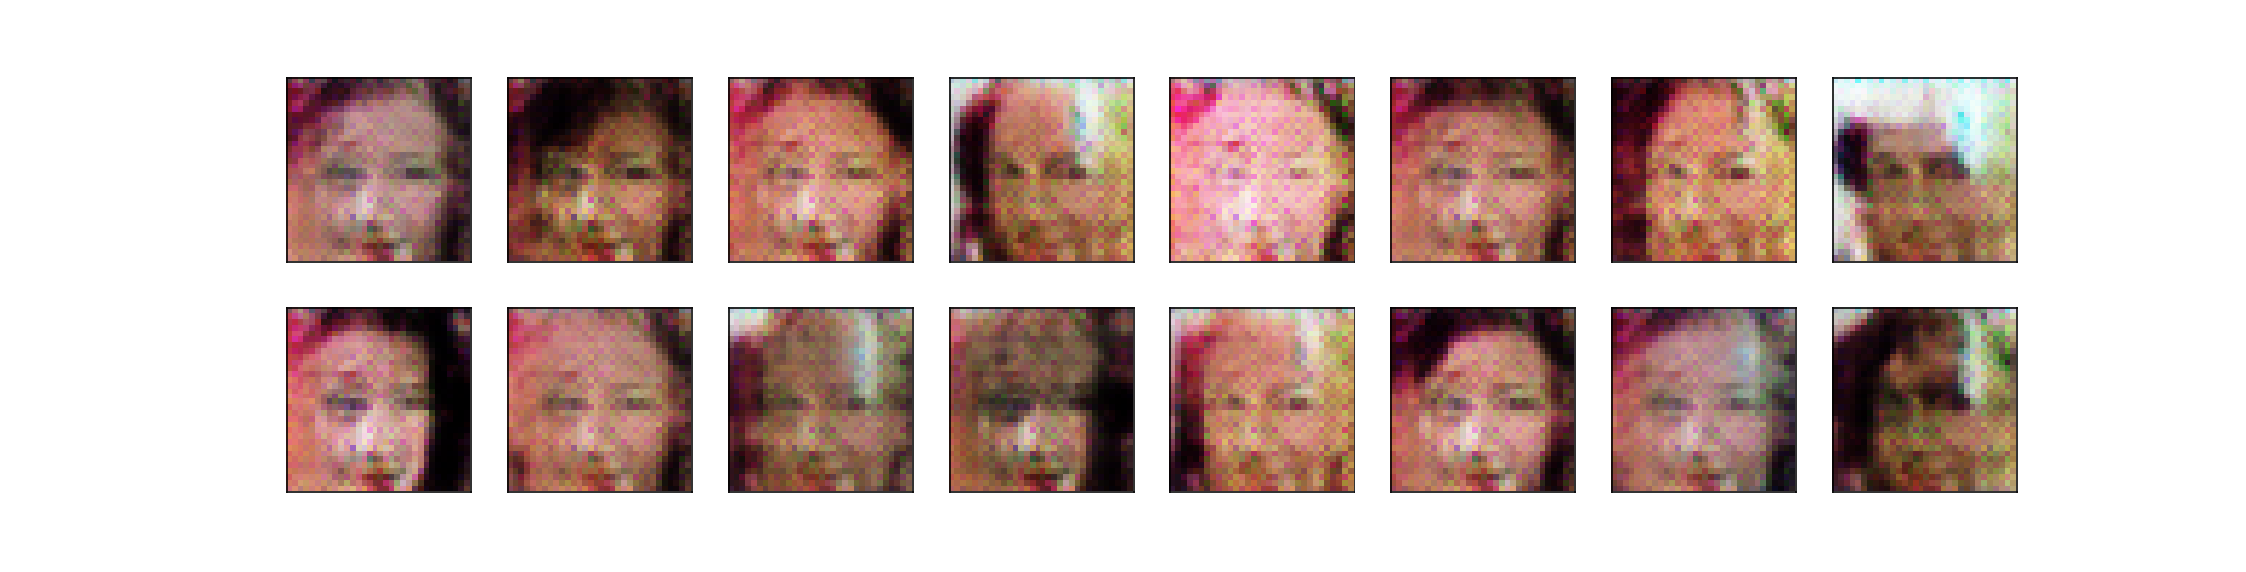

In [49]:
# n_epochs = 500
train_num = 5
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

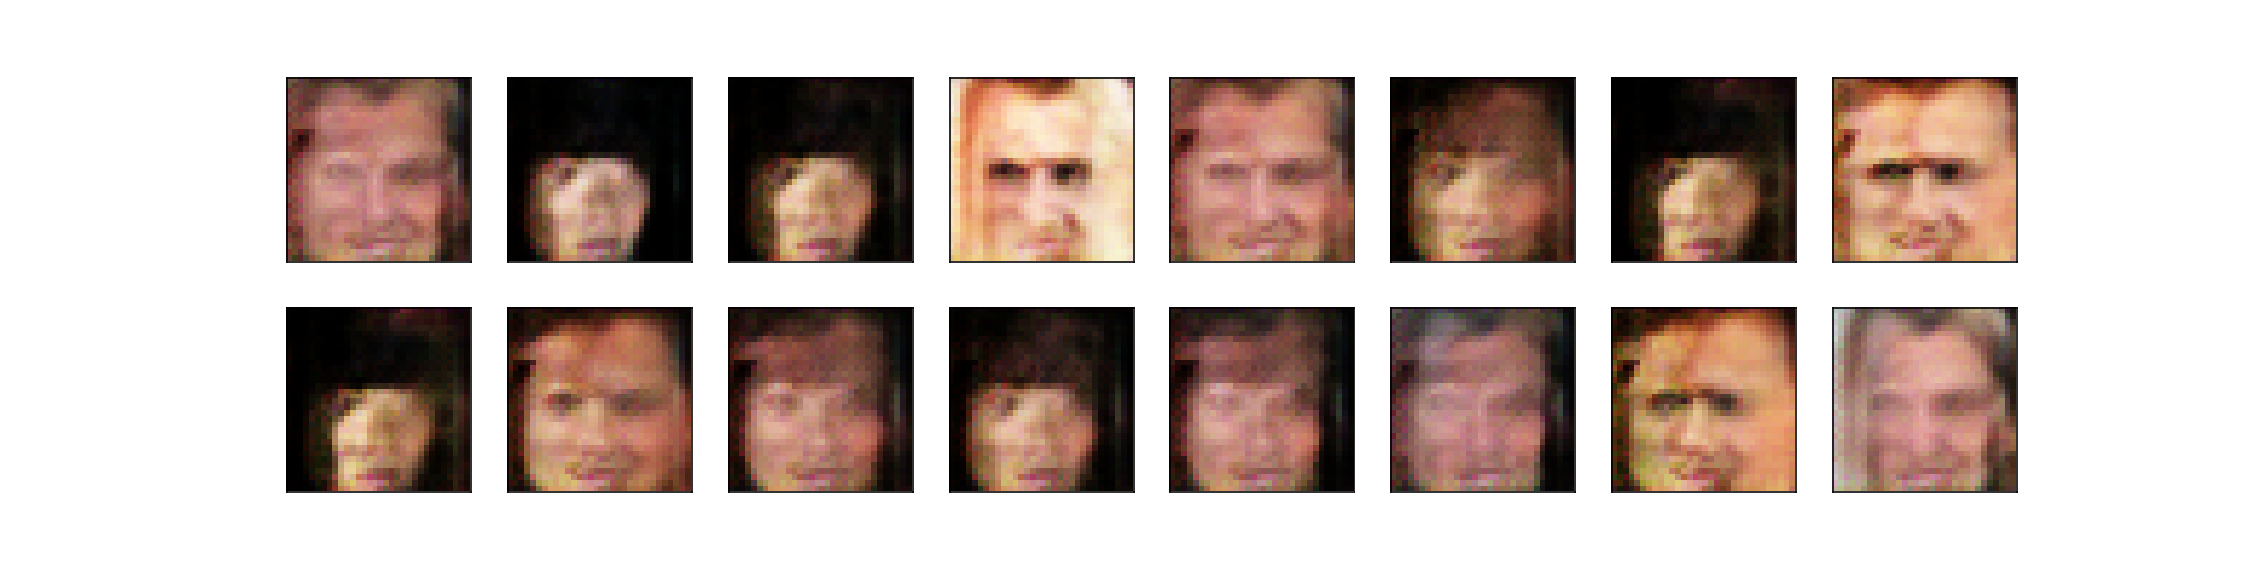

In [50]:
# n_epochs = 1000
train_num = 6
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

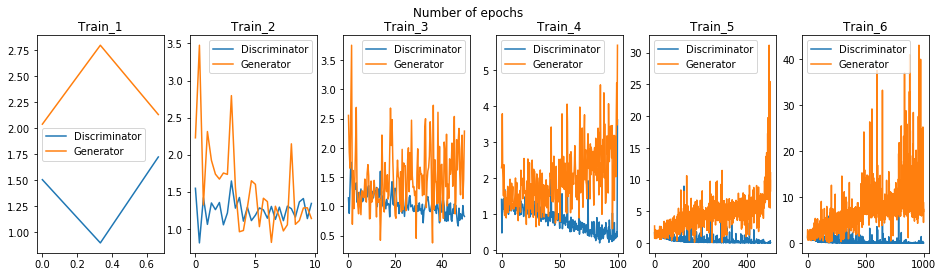

In [51]:
view_plots([[1, 'num_epochs', 3],
            [2, 'num_epochs', 3],
            [3, 'num_epochs', 3],
            [4, 'num_epochs', 3],
            [5, 'num_epochs', 3],
            [6, 'num_epochs', 3]], 'Number of epochs', 'n_epochs') 

### Result for parameter n_epochs:
Best value setting for the number of epochs extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. In both regimes the generated face images are blurred. In the following 100 epochs will be used for further parameter studies.

## Parameter: number of conv-layers and deconv-layers	

Parameters          | 4th Train-Run | 8th Train-Run | 
----------          | ------------- | ------------- |
batch_size          |   128         |   128         |  
img_size            |   32          |   32          | 
**deconv-layers**   |   `3`         |   `4`         |
**conv-layers**     |   `3`         |   `4`         | 
d_conv_dim          |   32          |   32          |
g_conv_dim          |   32          |   32          | 
z_size              |   100         |   100         |  
lr                  |   0.001       |   0.001       |  
beta1               |   0.5         |   0.5         | 
beta2               |   0.999       |   0.999       |
dropout             |   no          |   no          |
n_epochs            |   100         |   100         |

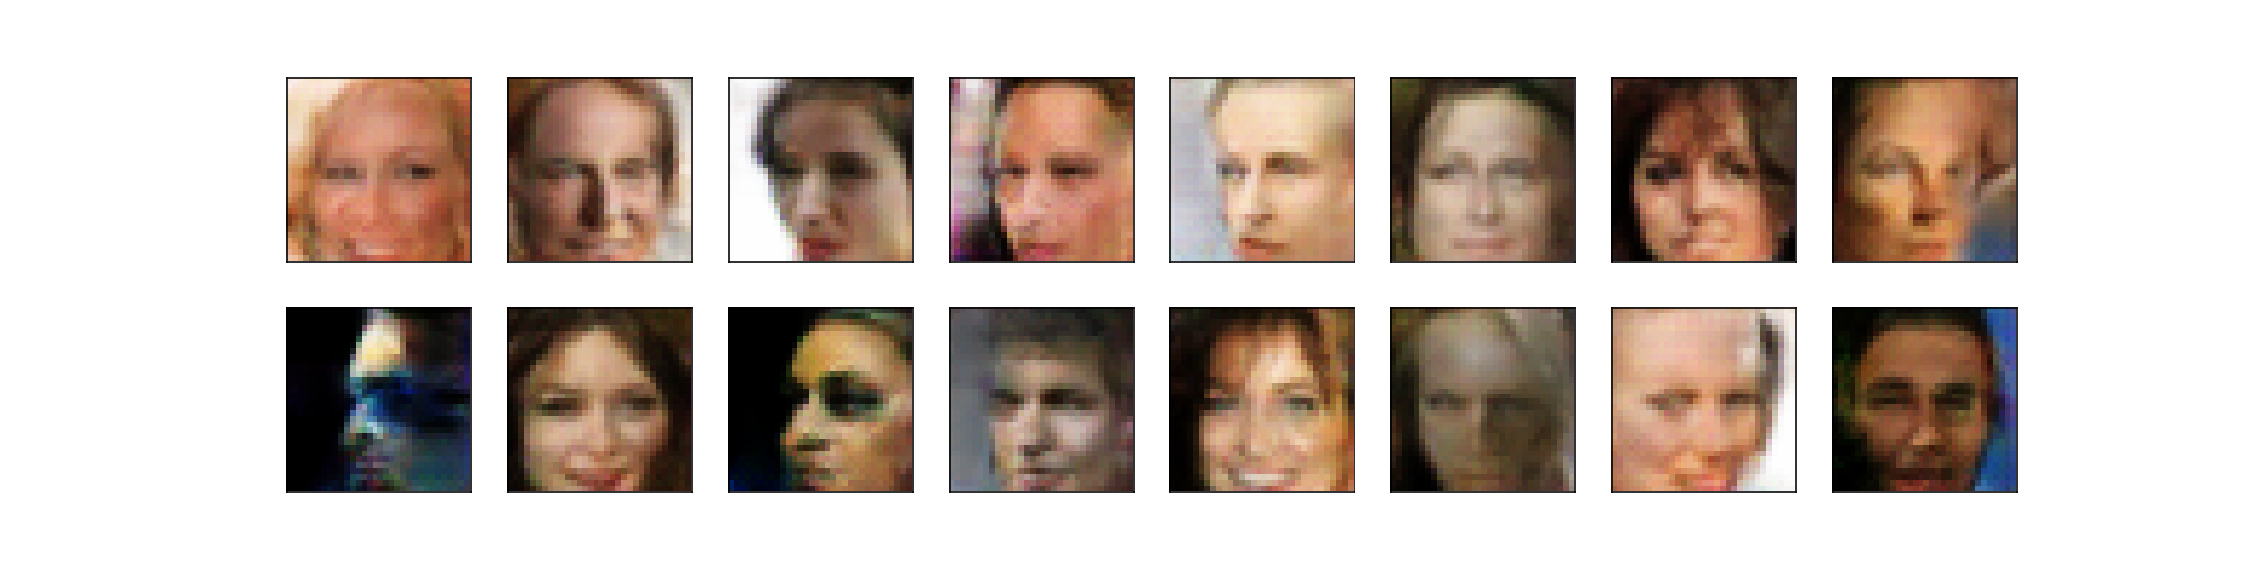

In [52]:
# conv-layers=3 and deconv-layers=3
train_num = 4
param = 'num_epochs'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

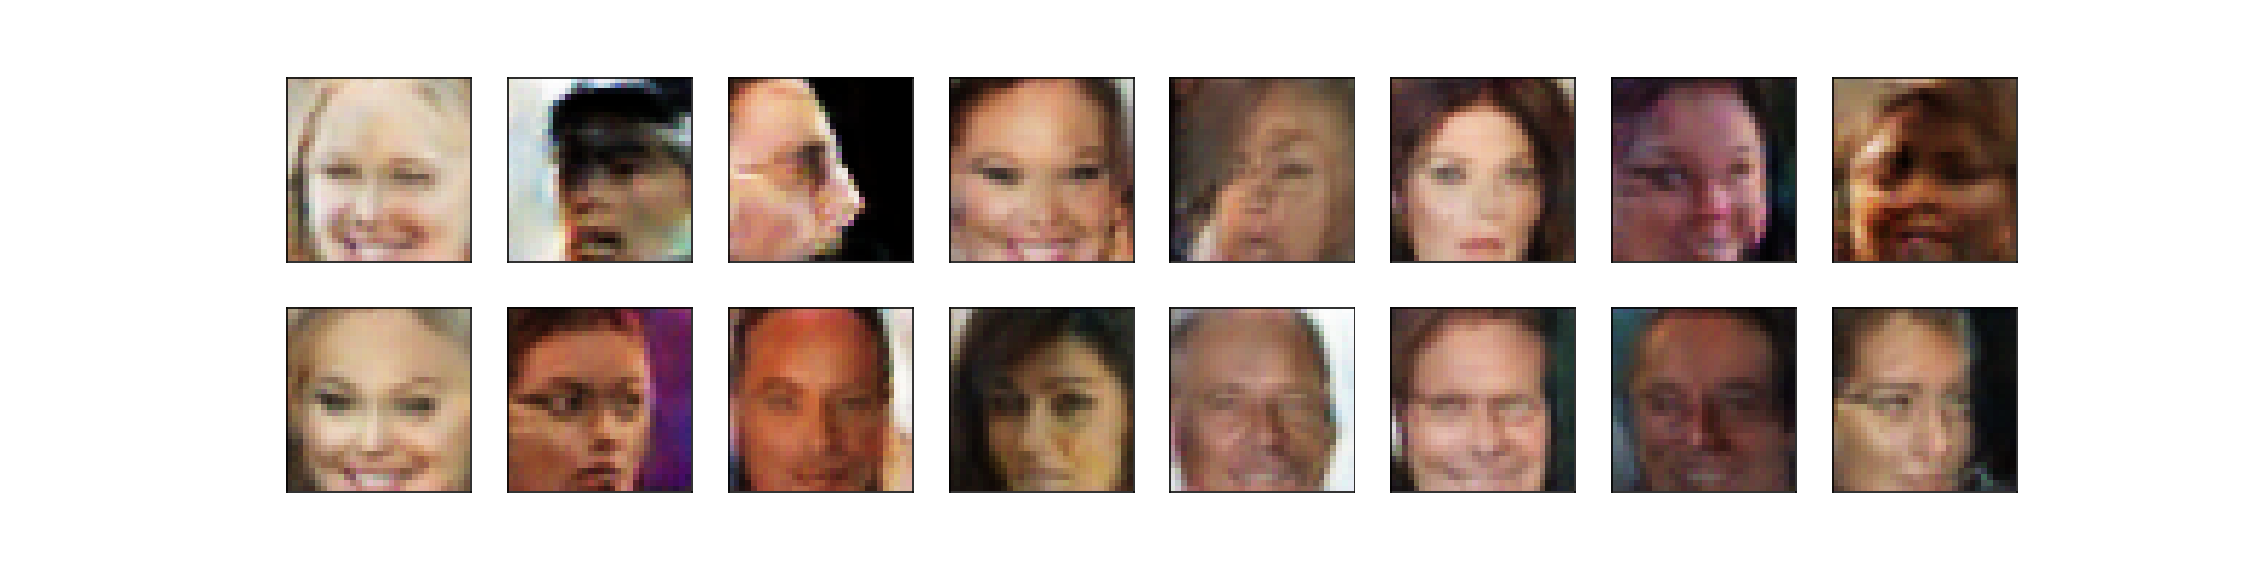

In [53]:
# conv-layers=4 and deconv-layers=4
train_num = 8
param = 'conv_deconv'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

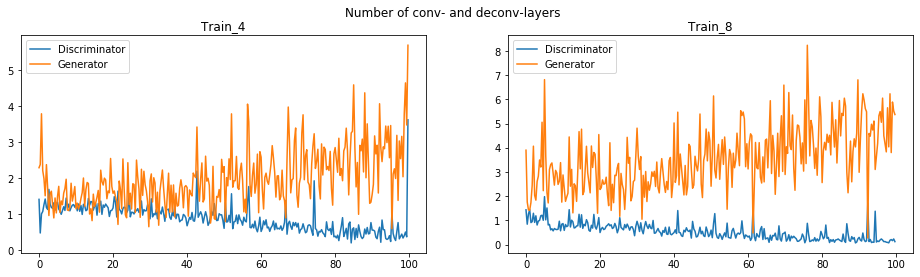

In [54]:
view_plots([[4, 'num_epochs', 3],
            [8, 'conv_deconv', 3]],'Number of conv- and deconv-layers', 'conv_deconv')  

### Result for parameter number of conv-layers and deconv-layers:
There is no clear trend with regard to the number of conv-layers and deconv-layers. Corresponding images for conv-layers=3 and deconv-layers=3 look similar to conv-layers=4 and deconv-layers=4. However, the trend of losses is slightly better for conv-layers=4 and deconv-layers=4, higher (positive) loss for the Generator and slightly lower loss for the Discriminator. In the following conv-layers=4 and deconv-layers=4 will be used for further parameter studies.

## Parameter: batch_size

Parameters          | 14th Train-Run | 15th Train-Run | 16th Train-Run  | 17th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
**batch_size**      |   `64`        |   `128`         |   `256`         |  `512`         |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
d_conv_dim          |   32          |   32            |   32            |   32           |   
g_conv_dim          |   32          |   32            |   32            |   32           |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

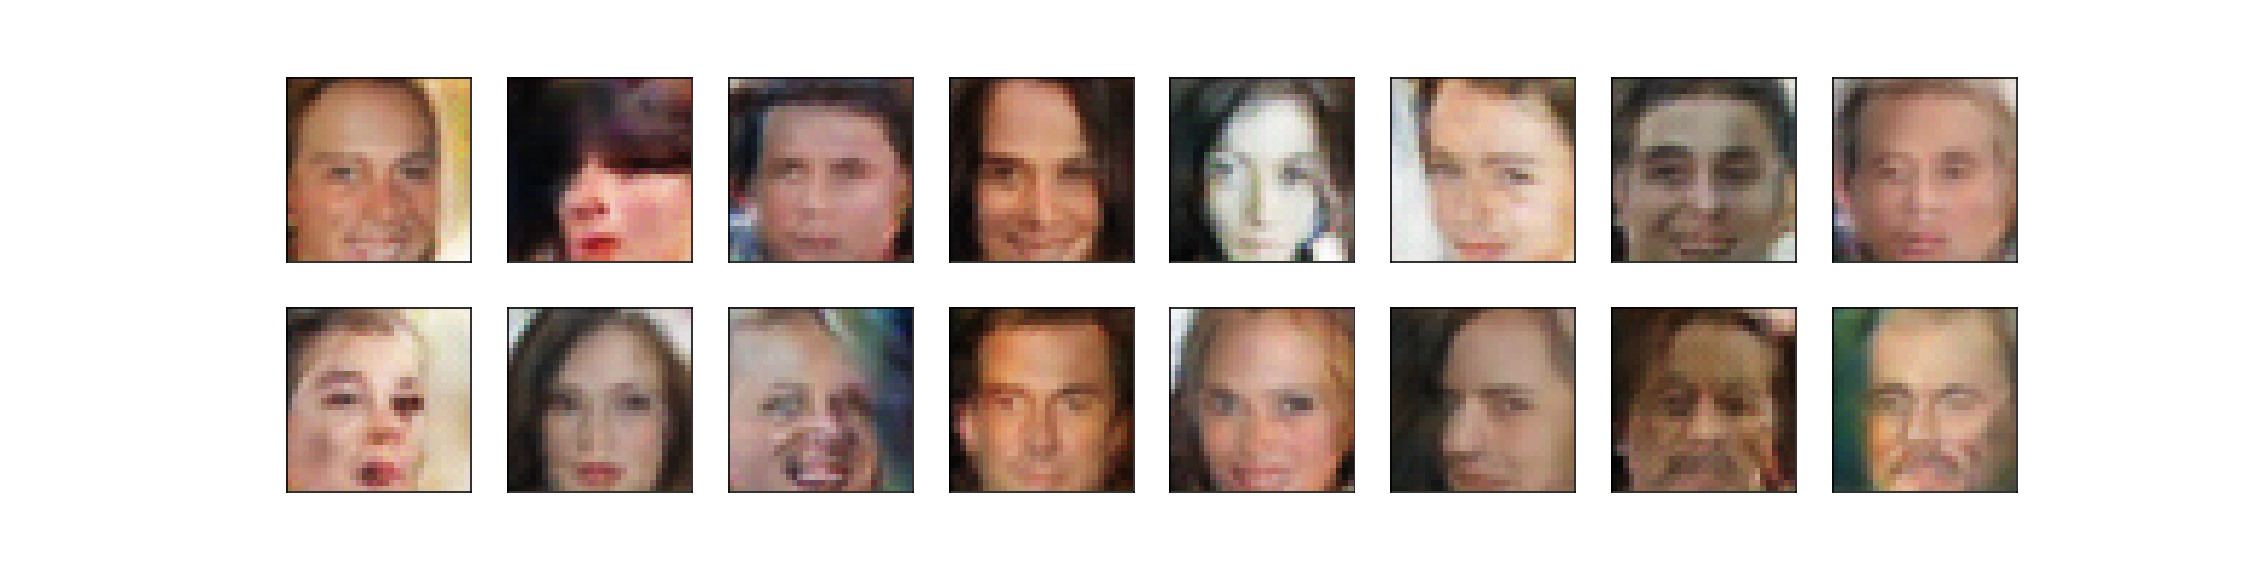

In [55]:
# batch_size=64
train_num = 14
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

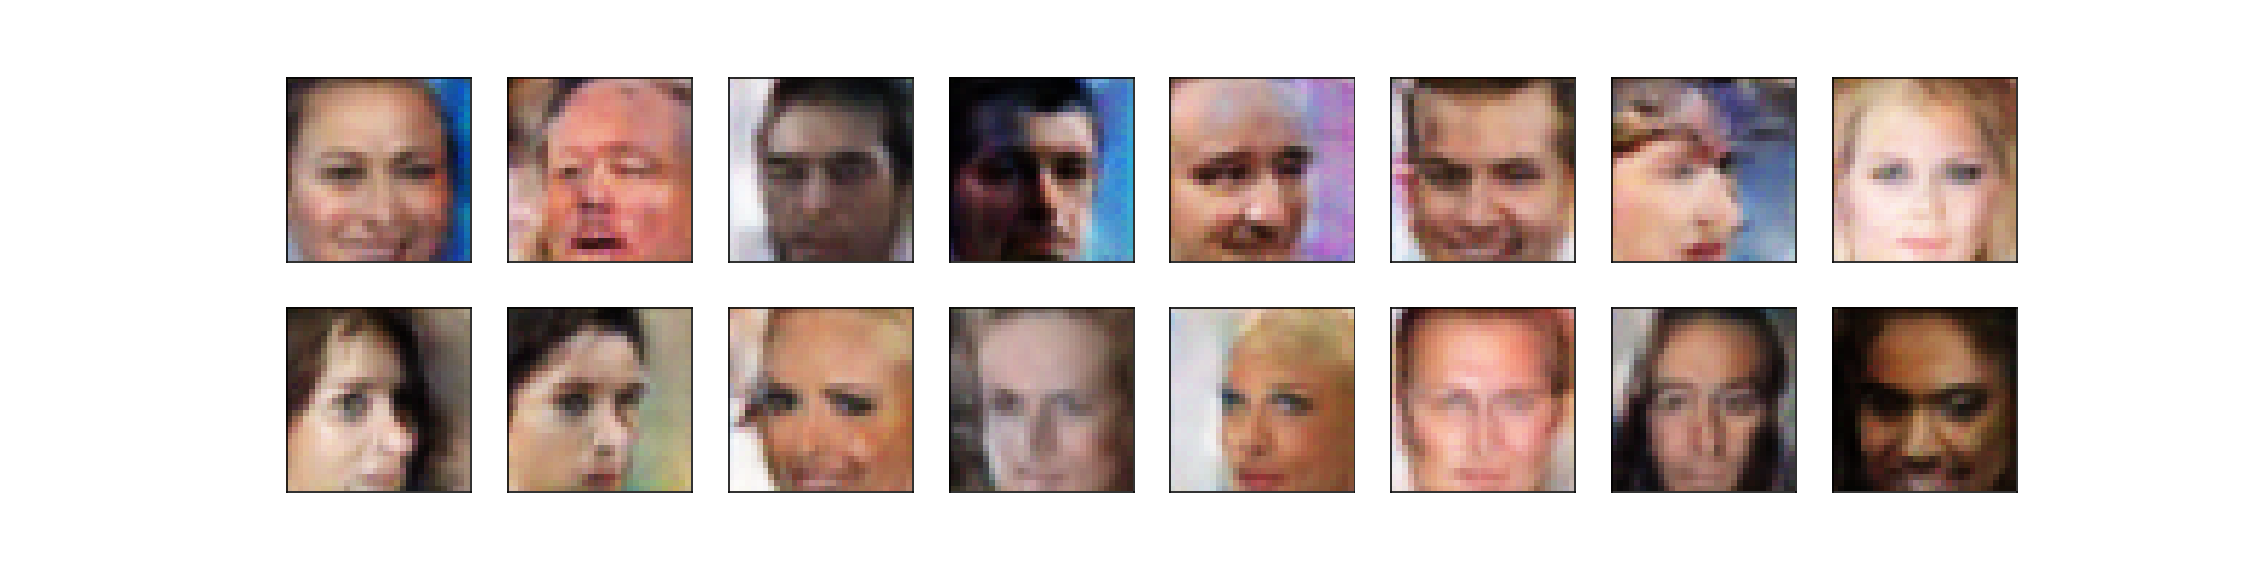

In [56]:
# batch_size=128
train_num = 15
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

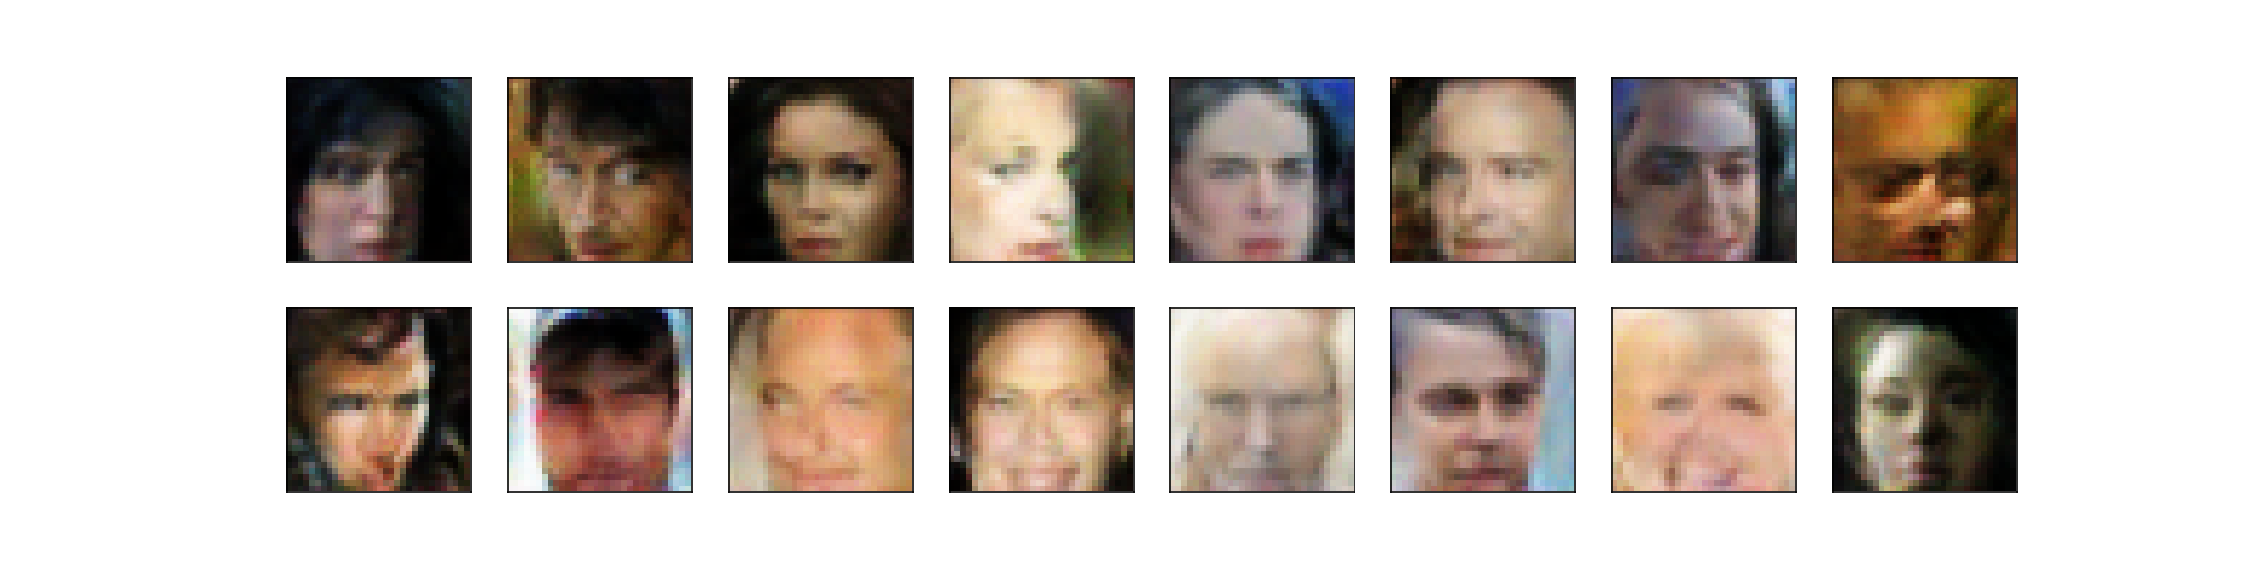

In [57]:
# batch_size=256
train_num = 16
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

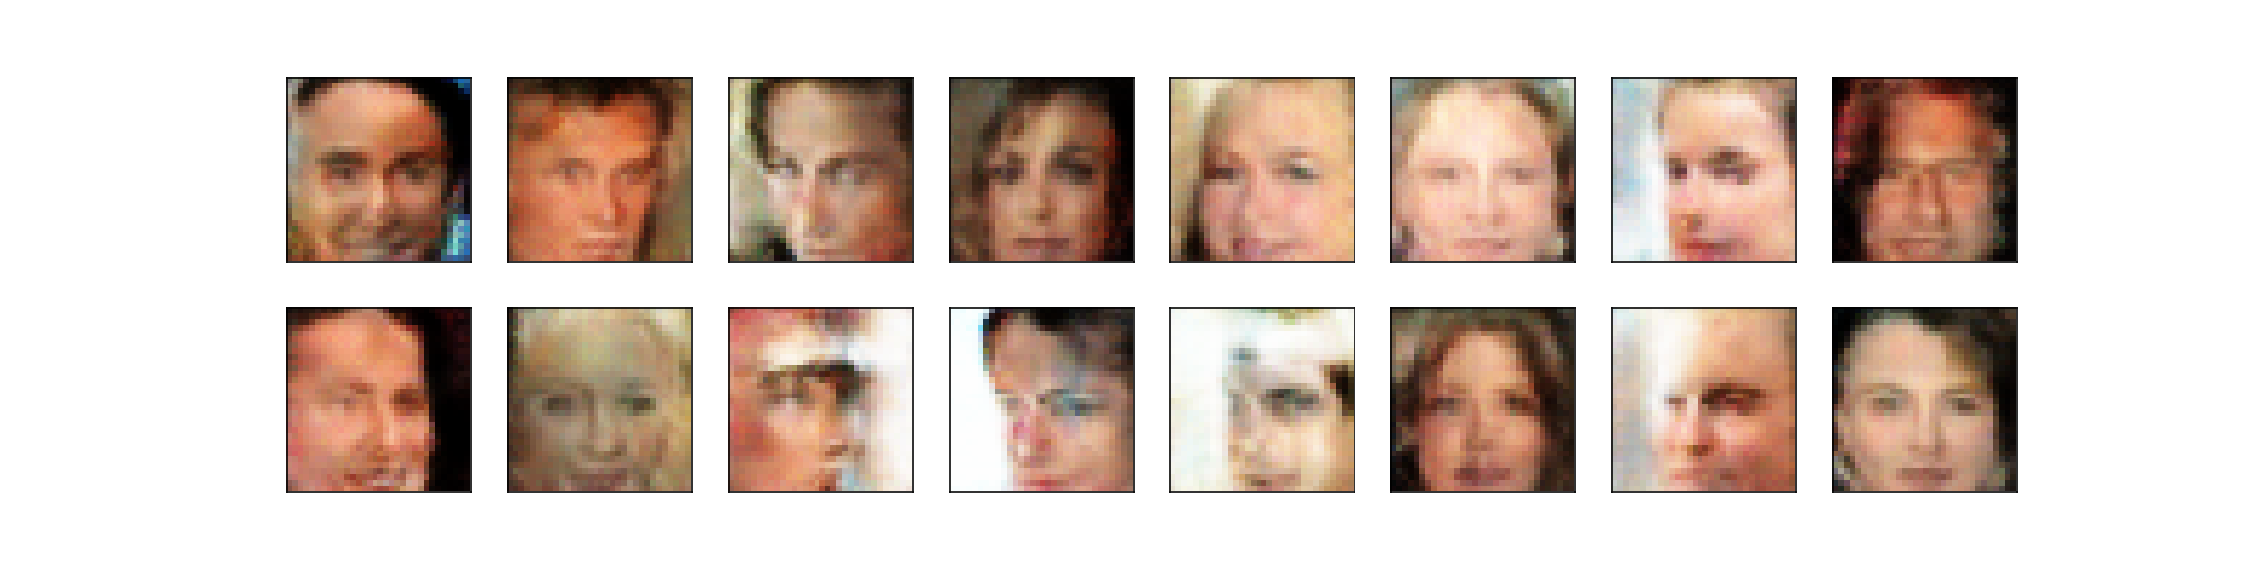

In [58]:
# batch_size=512
train_num = 17
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

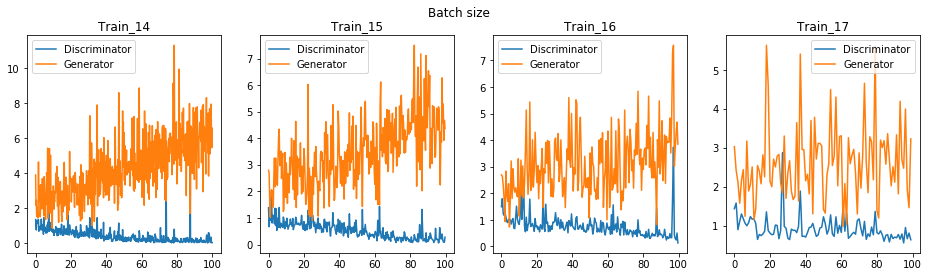

In [59]:
view_plots([[14, 'batch_size', 5],
            [15, 'batch_size', 3],
            [16, 'batch_size', 2],
            [17, 'batch_size', 1]], 'Batch size', 'batch_size') 

#### Result for parameter batch_size:
A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse. This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. For the further study a batch_size of 128 has been chosen.

## Parameter: conv_dim

Parameters          | 8th Train-Run | 11th Train-Run  | 12th Train-Run  | 13th Train-Run |
----------          | ------------- | -------------   | -------------   | -------------  |
batch_size          |   128         |   128           |   128           |  128           |   
img_size            |   32          |   32            |   32            |   32           |
deconv-layers       |   4           |   4             |   4             |   4            |
conv-layers         |   4           |   4             |   4             |   4            |
**d_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |   
**g_conv_dim**      |   `32`        |   `64`          |   `128`         |  `256`         |
z_size              |   100         |   100           |   100           |   100          |   
lr                  |   0.001       |   0.001         |   0.001         |   0.001        |  
beta1               |   0.5         |   0.5           |   0.5           |   0.5          |
beta2               |   0.999       |   0.999         |   0.999         |   0.999        |
dropout             |   no          |   no            |   no            |   no           |
n_epochs            |   100         |   100           |   100           |   100          |

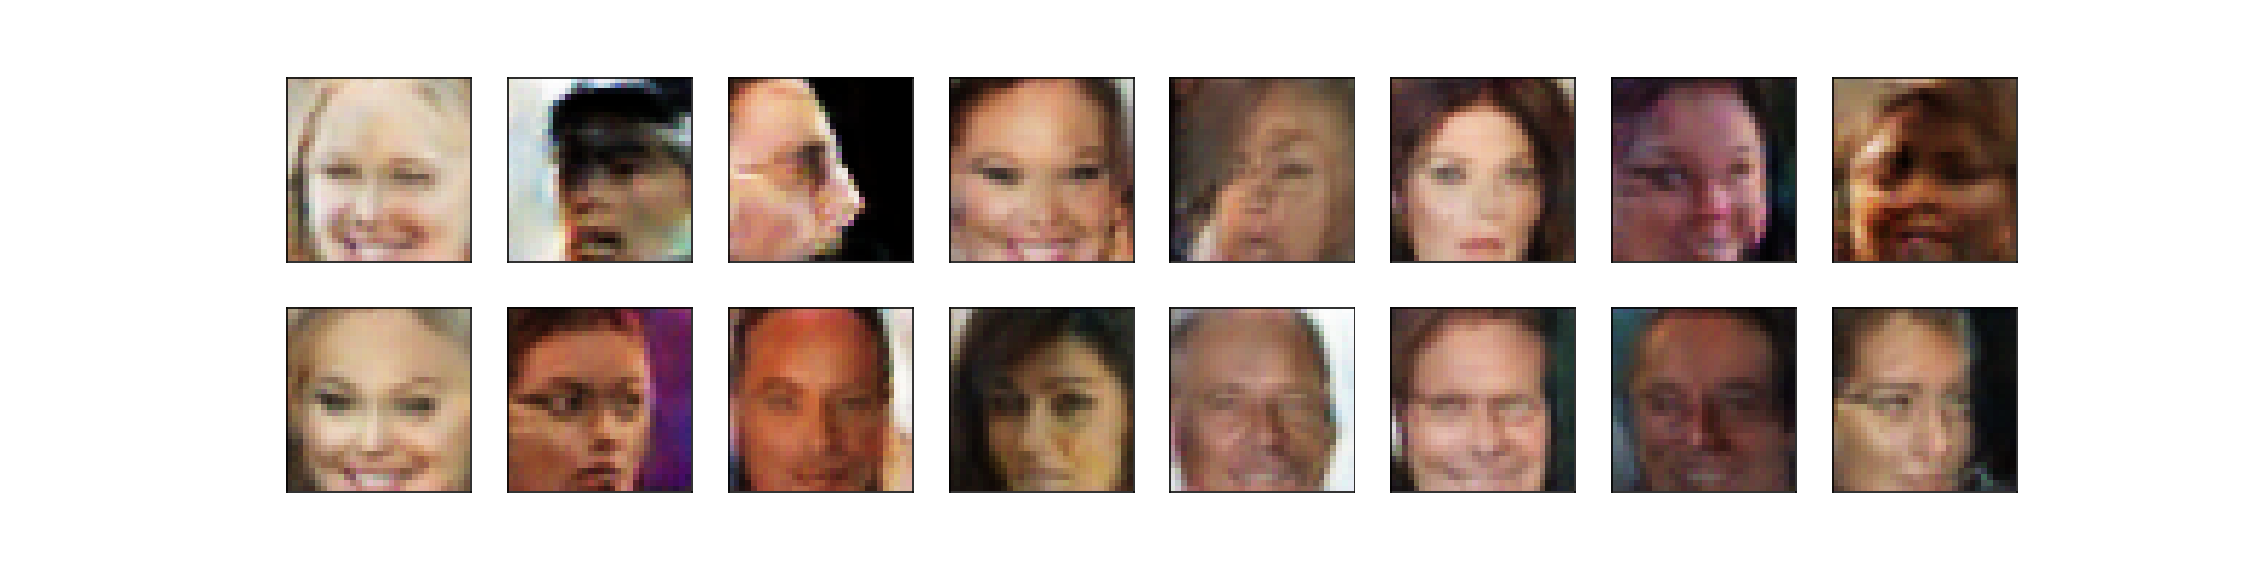

In [60]:
# d_conv_dim=32 and g_conv_dim=32
train_num = 8
param = 'conv_deconv'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

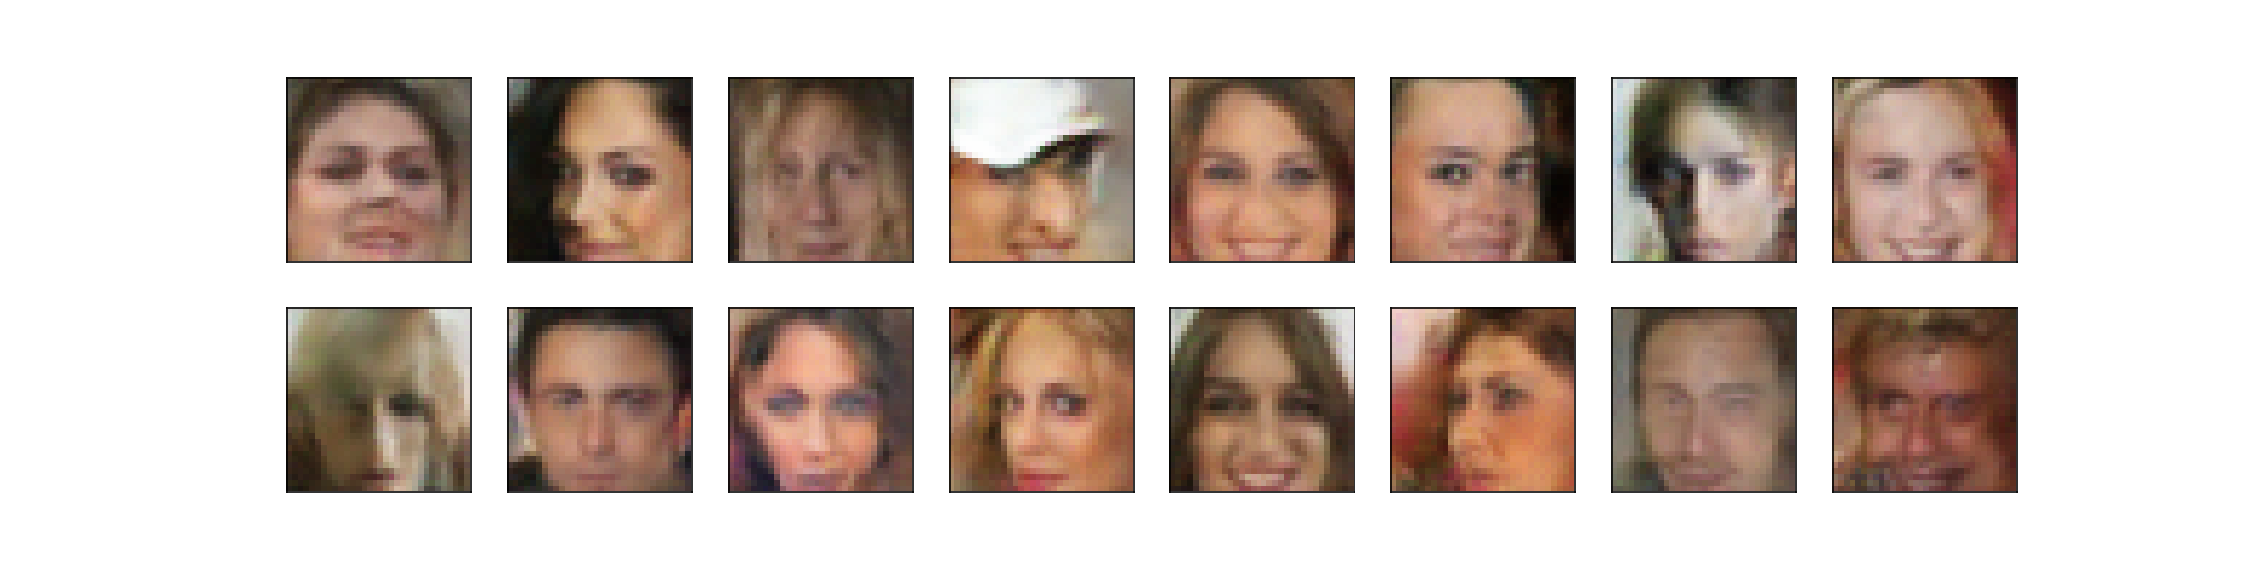

In [61]:
# d_conv_dim=64 and g_conv_dim=64
train_num = 11
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

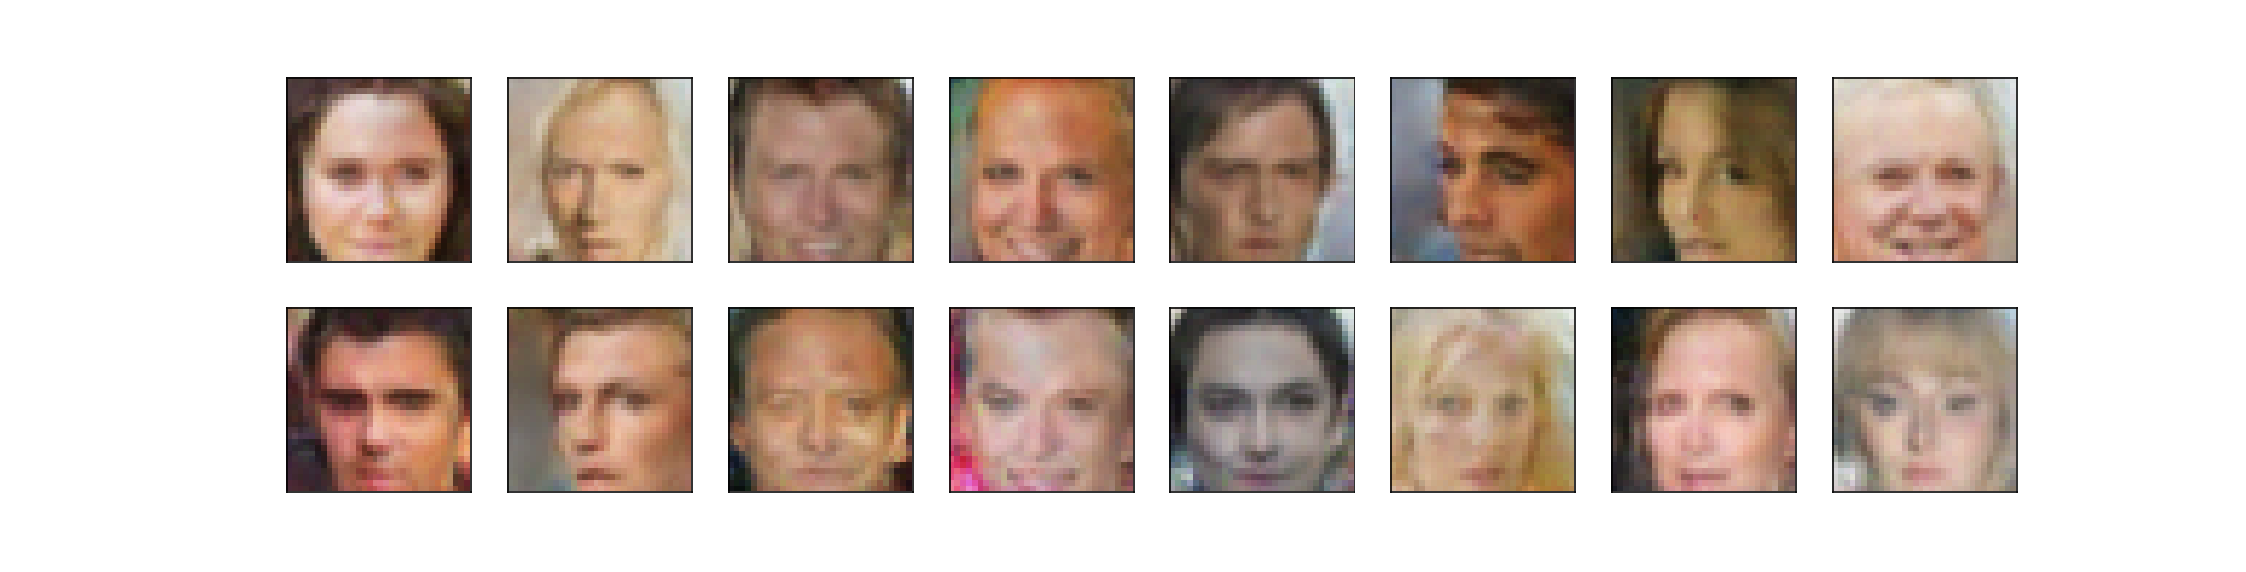

In [62]:
# d_conv_dim=128 and g_conv_dim=128
train_num = 12
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

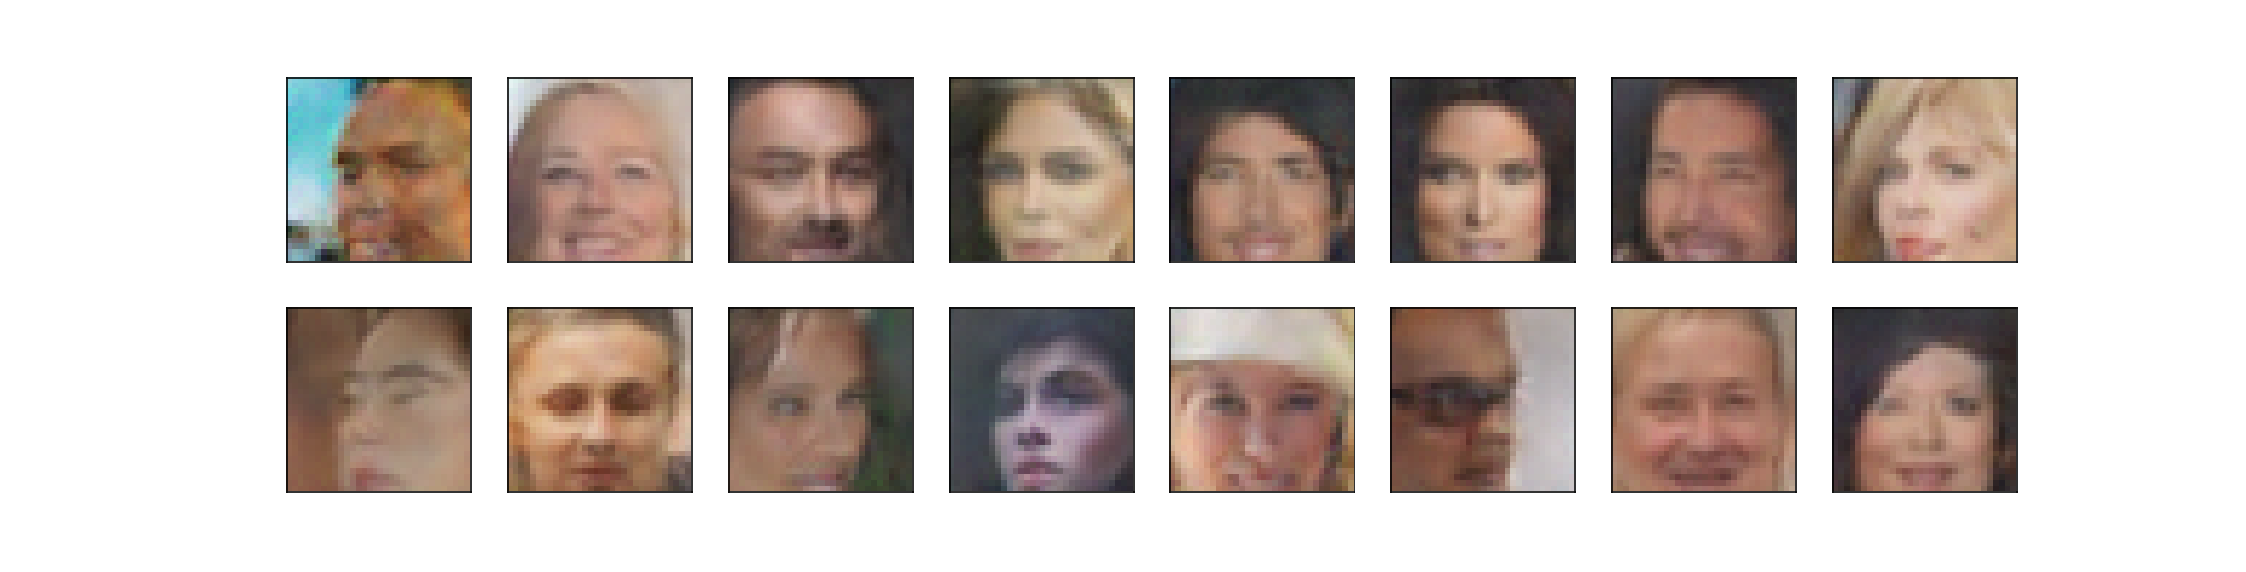

In [63]:
# d_conv_dim=256 and g_conv_dim=256
train_num = 13
param = 'conv_dim'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

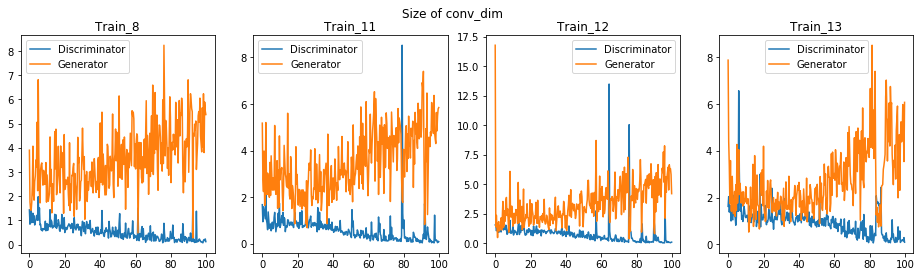

In [64]:
view_plots([[8, 'conv_deconv', 3],
            [11, 'conv_dim', 3],
            [12, 'conv_dim', 3],
            [13, 'conv_dim', 3]], 'Size of conv_dim', 'conv_dim') 

#### Result for parameter conv_dim:
With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

### Parameter: lr

Parameters          | 21th Train-Run | 14th Train-Run  | 22th Train-Run |
----------          | ------------- | -------------   | -------------   |
batch_size          |   128         |   128           |   128           |   
img_size            |   32          |   32            |   32            |   
deconv-layers       |   4           |   4             |   4             |   
conv-layers         |   4           |   4             |   4             |   
d_conv_dim          |   64          |   64            |   64            |    
g_conv_dim          |   64          |   64            |   64            |   
z_size              |   100         |   100           |   100           |    
**lr**              |   `0.01`      |   `0.001`       |   `0.0001`      |   
beta1               |   0.5         |   0.5           |   0.5           |   
beta2               |   0.999       |   0.999         |   0.999         |   
dropout             |   no          |   no            |   no            |   
n_epochs            |   100         |   100           |   100           | 

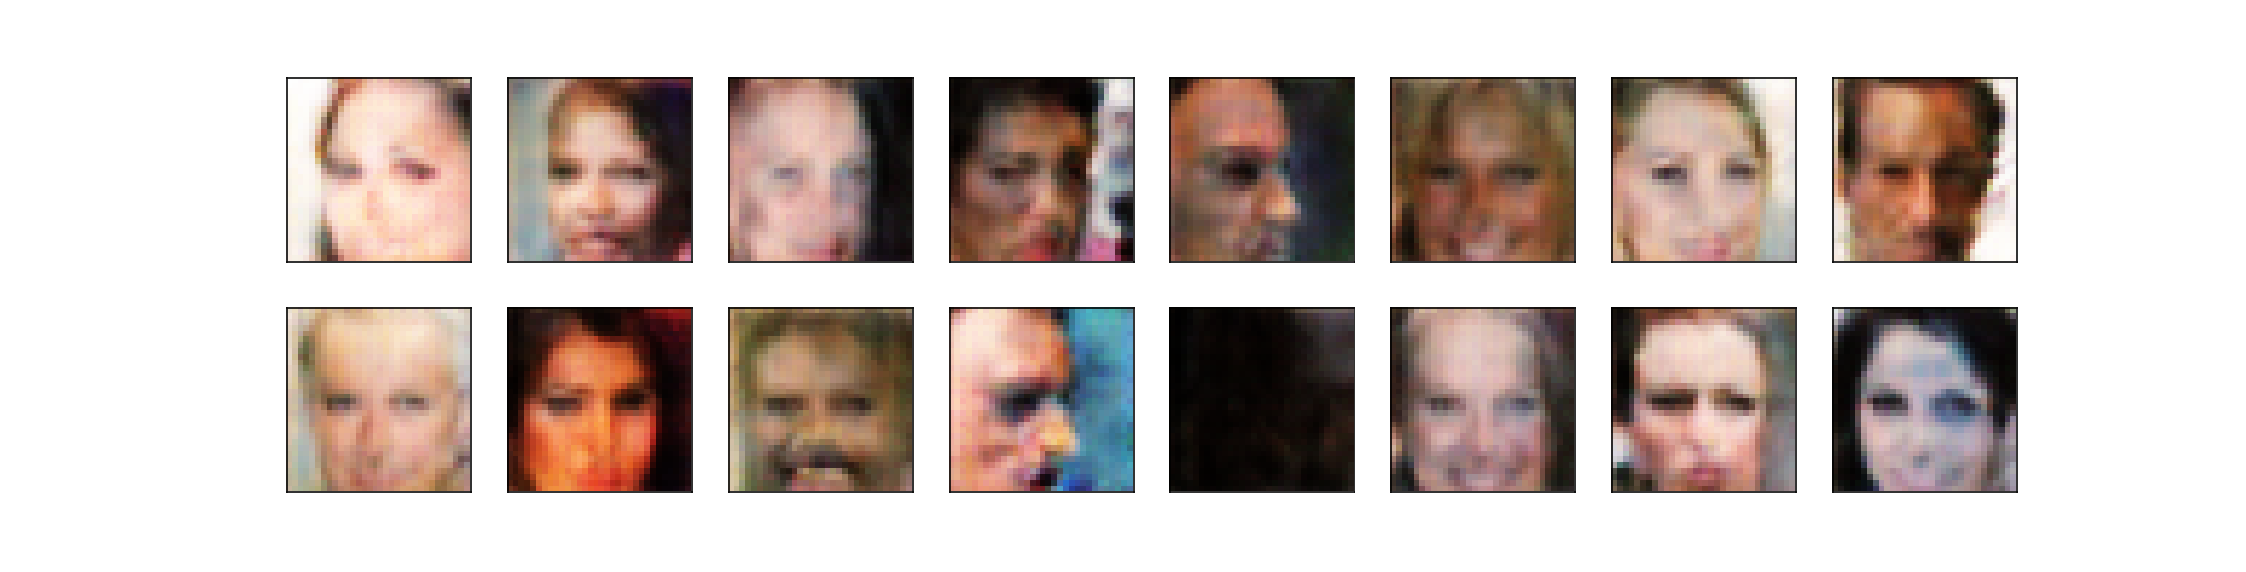

In [65]:
# lr=0.01
train_num = 21
param = 'lr'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

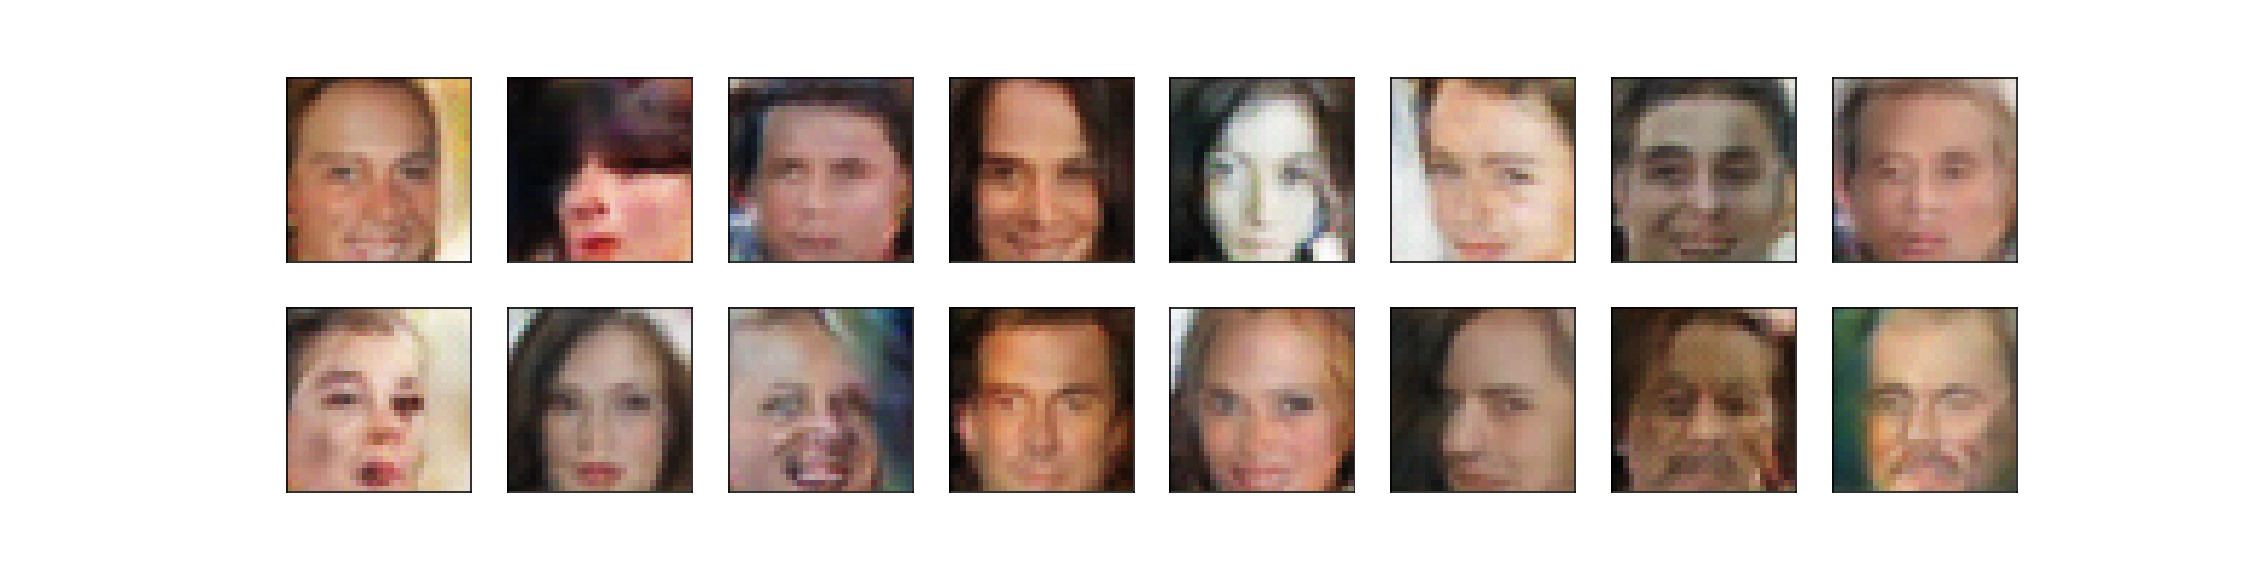

In [66]:
# lr=0.001
train_num = 14
param = 'batch_size'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

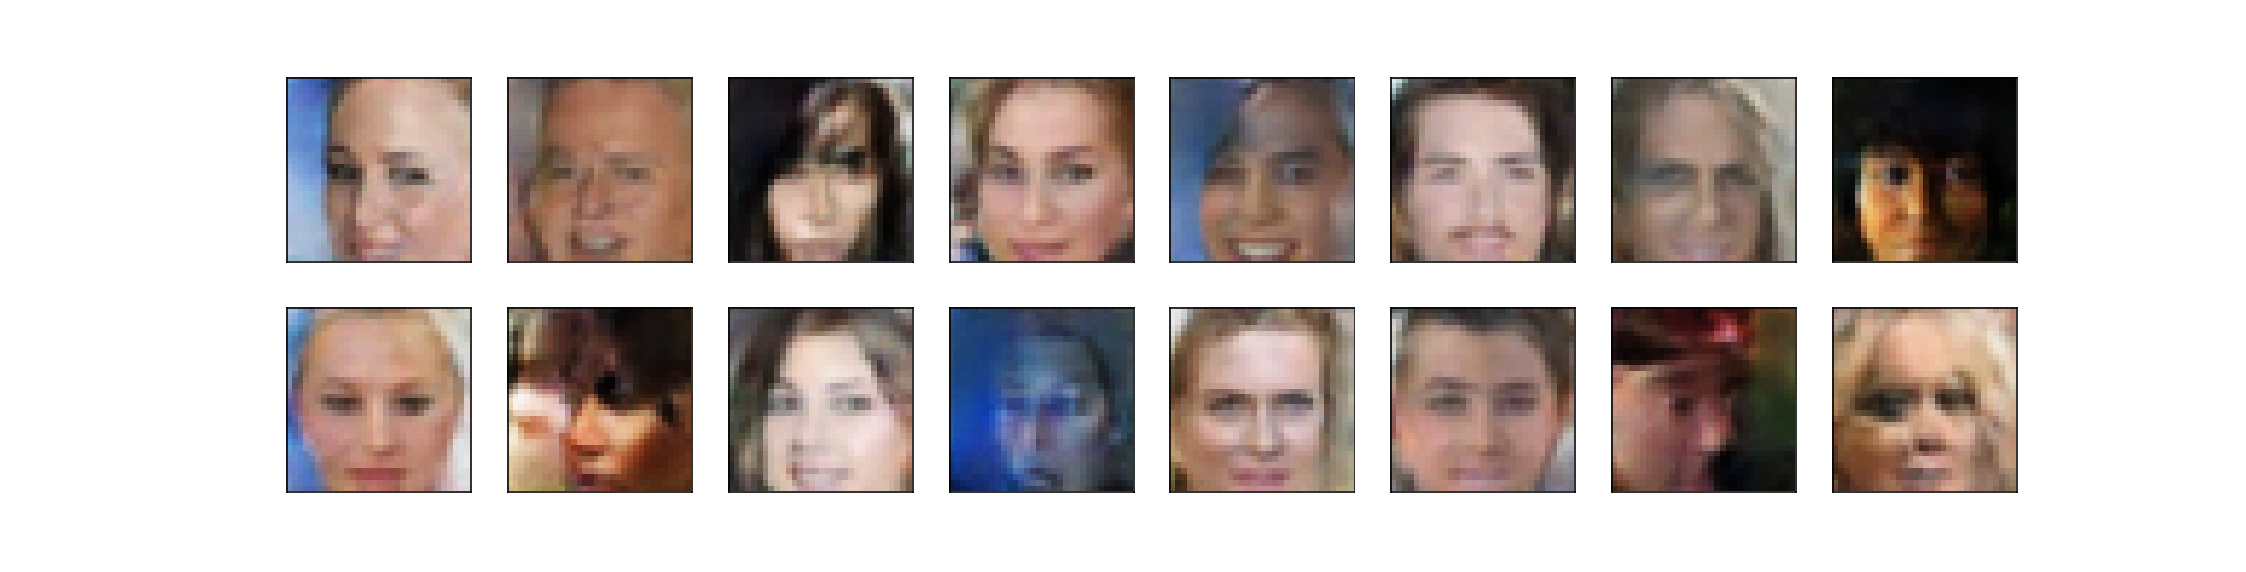

In [67]:
# lr=0.0001
train_num = 22
param = 'lr'
# plot pkl file
"""
with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)
"""
# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

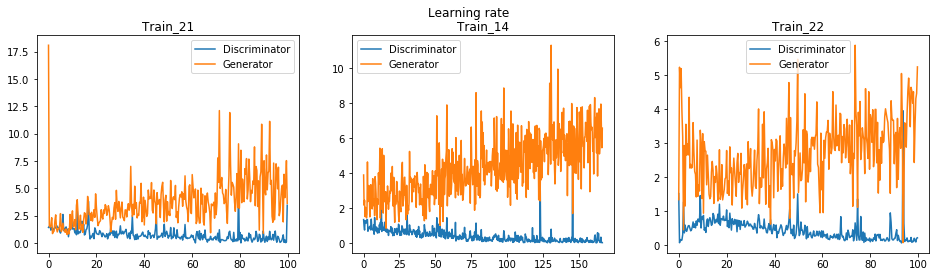

In [68]:
view_plots([[21, 'lr', 3],
            [14, 'batch_size', 3],
            [22, 'lr', 3]], 'Learning rate', 'lr')

#### Result for parameter lr:
Learning rates in the range between 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces are successfully constructed. However,  a learning rate of lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Final hyperparameter setting
The following table shows the best-of setting of the investigated parameter tuning.

Parameters          | 14th Train-Run|
----------          | ------------- |
batch_size          |   128         |  
img_size            |   32          |  
deconv-layers       |   4           |  
conv-layers         |   4           |  
d_conv_dim          |   64          |    
g_conv_dim          |   64          |  
z_size              |   100         |  
lr                  |   0.0001       |   
beta1               |   0.5         |   
beta2               |   0.999       |     
dropout             |   no          |   
n_epochs            |   100         | 

### Final fake image output

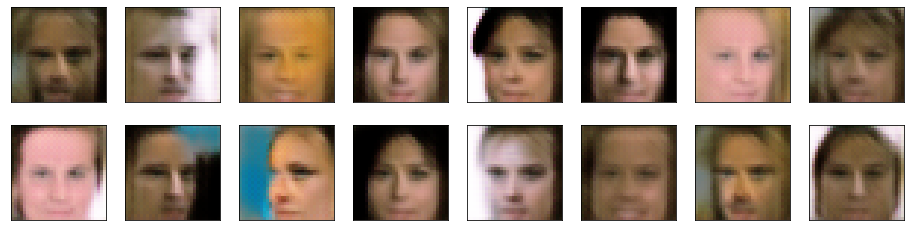

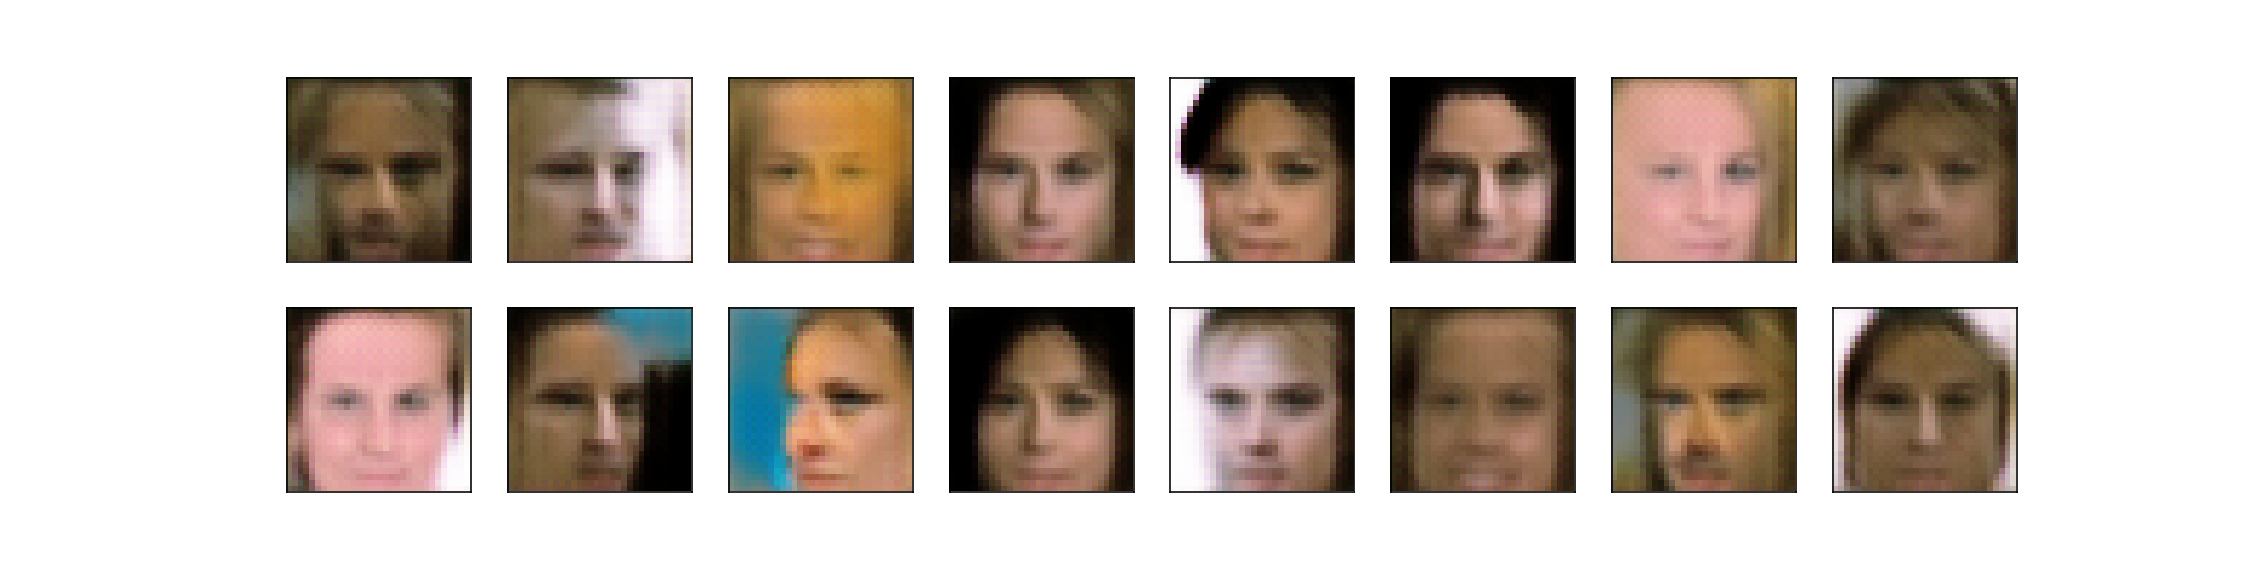

In [69]:
# images for reasonable setting
train_num = 26
param = 'lr'
# plot pkl file

with open('training_results_pkl/train_' + str(train_num) + '_' + param + '_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
_ = view_samples_2(-1, samples, train_num)

# plot png file
plt.figure(figsize=(40,20))
img = plt.imread('image_sets/train_' + str(train_num) + '.png')
plt.axis('off')
plt.imshow(img)

### Corresponding loss for the final setting

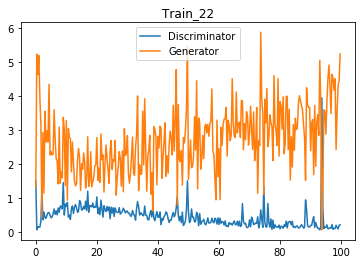

In [70]:
# loss for reasonable setting
train_num = 22
param = 'lr'
fig, ax = plt.subplots()
df = pd.read_excel('training_results/train_' + str(train_num) + '_' + str(param) + '.xlsx')  # doctest: +SKIP
loss_d = df['Discriminator'].values
loss_g = df['Generator'].values
plt.plot(df.index/3, loss_d, label='Discriminator')
plt.plot(df.index/3,loss_g, label='Generator')
plt.title("Train_22")
plt.legend()
fig.savefig('plots/train_22_single.png')

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Reasons for the chosen final hyperparameter setting:
A whole bunch of parameters setting were tested in sequences (see evaluation above). 

#### n_epochs:
n_epochs was varied between 1 and 1000. Its best value setting extends to the range 50...100. Lower epoch values lead to underfitting, higher epoch values tend to pronounced noisy behavior of the discriminator loss. For both extreme regimes the generated face images are blurred. Therefore n_epochs was set to 100.

#### number of conv-layers and deconv-layers:
Two models were constructed: one with 3 and another one with 4 conv and deconv layers for the discriminator and generator, respectively. Corresponding images for conv-layers=deconv-layers=3 look similar to conv-layers=deconv-layers=4. Hence, a clear trend is hard to distinguish in these examples. However, the trend of losses is slightly better for conv-layers=deconv-layers=4 than for conv-layers=deconv-layers=3, i.e. the loss for the Generator is higher and the loss for the Discriminator is slightly lower. Therefore conv-layers=4 and deconv-layers=4 have been used for further parameter studies.

#### batch_size:
The value range for the batch_size was chosen between 64 and 512. A larger batch_size has a positive effect on the computational boost. However, if the batch_size is getting too high the feature resolution is getting worse (more blurred). This can be clearly seen if one compares a batch_size of 512 with a batch_size of 128. Therefore a batch_size of 128 has been chosen. Up to a batch_size of 512 no out-of-memory errors were observed (getting critical for higher batch_sizes).

##### conv_dim:
The conv_dim value was investigated in the range between 32 and 256. With a higher conv_dim for the Generator and the Discriminator the resolution of feature details is getting higher. For example, eyes are better resolved with a conv_dim=256 than with a conv_dim=32. However, even a conv_dim of 64 leads to convincing results.

#### lr:
As learning rates 0.01, 0.01 and 0.0001 were tested. In all three cases the GAN is able to learn and generated fake images of faces successfully. However, lr=0.001 or lr=0.0001 lead to a slightly better feature resolution than lr = 0.01.

### Further improvements:
- To overcome the issue of a biased dataset (celebrity faces that are mostly white): one could add more images of non-white celebrity faces to get a more balanced dataset in the end.
    
- The model size is limited by the number of conv-layers and deconv-layers which was set to 4 in maximum. Higher values were not tested so far. Increasing the model size could especially enhance the feature extraction of the Discriminator. The adversarial Generator is then forced to produce images with better feature resolution.

- A further increase of the conv_dim could lead to better results. However, this would significantly increase the training time.

- The dataset images are 64x64x3 NumPy images. In the get_dataloader function I resized the images down to 32x32x3. This is the image size for the Discriminator input and the size of the Generator output. This resolution of the generated images is noisy. If one would keep width=64 and height=64 the images could resemble more the original ones. However, this would also increase the training duration.

- Regarding the optimizer strategy: For the Discriminator as well as for the Generator the same type of optimizer (Adam) was chosen with a learning rate down to 0.0001. A combination of different optimizer like SGD for the Discriminator and Adam for the Generator as proposed by [Soumith](https://github.com/soumith/ganhacks) has not been tested yet.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.